<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de bibliotecas

In [1]:
# Install the needed libraries for PINNs
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
from typing import Callable, Tuple, Optional, Union, List, Any
from dataclasses import dataclass, field
import jax
from jax import random, grad, vmap, jit, value_and_grad
from functools import partial
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax.training.train_state import TrainState
import optax

In [3]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import linprog
from sklearn.metrics import r2_score
# from docplex.mp.model import Model
import warnings
import time
import itertools

## Parâmetros de Entrada

In [4]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
p0 = 332.00
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

## Ajuste PVT

In [5]:
pvt_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_pvt.xlsx')
pvt_df.head()

,p,Rs_ext,Bo_ext,Bg,viso,visg,co,Rs,Bo
0,35.49,31.80,1.198,0.0346,2.05,0.0109,0.000162,31.80,1.198
1,41.82,34.66,1.200,0.0291,1.99,0.0113,0.000162,34.66,1.200
2,49.20,38.02,1.210,0.0245,1.91,0.0117,0.000162,38.02,1.210
3,59.75,42.83,1.230,0.0199,1.81,0.0123,0.000162,42.83,1.230
4,68.54,46.85,1.240,0.0172,1.73,0.0128,0.000162,46.85,1.240


0.0012078946324729843 1.1537752108328592


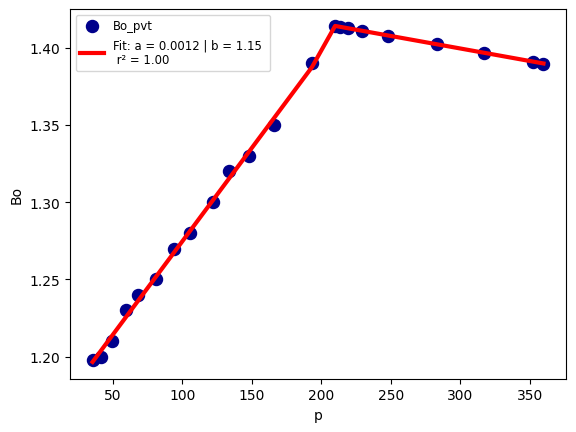

In [6]:
## Ajuste Bo

p_pvt=pvt_df["p"].values
bo_pvt=pvt_df["Bo"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
bo_adj = bo_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_bob(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_bob, p_adj, bo_adj, initialGuess)
bo_a, bo_b = popt[0], popt[1]
print(bo_a, bo_b)

## Função Bo
def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

## Valores previstos
bo_prev = func_bo(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bo_pvt, bo_prev)

## Gráfico comparativo Bo x Bo_prev
plt.scatter(p_pvt, bo_pvt, label="Bo_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, bo_adj, label="Bo_adj", color="darkorange", s=75)
plt.plot(p_pvt, bo_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bo")
plt.show()

1.5059386355535889 -1.0574564793690788


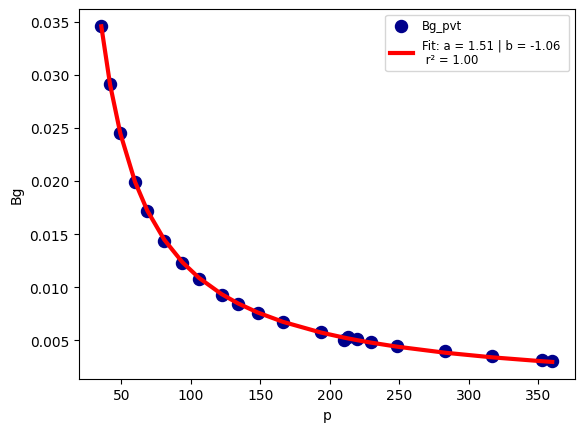

In [7]:
## Ajuste Bg

bg_pvt=pvt_df["Bg"].values

## Ajuste de uma reta por mínimos quadrados
def func_bg(p, a, b):
    return a*p**(b)

initialGuess=[1,-1]
popt, pcov = curve_fit(func_bg, p_pvt, bg_pvt, initialGuess)
bg_a, bg_b = popt[0], popt[1]
print(bg_a, bg_b)

## Valores previstos
bg_prev = func_bg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bg_pvt, bg_prev)

## Gráfico comparativo Bg x Bg_prev
plt.scatter(p_pvt, bg_pvt, label="Bg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, bg_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bg")
plt.show()

0.46549860654998376 15.011424226022424


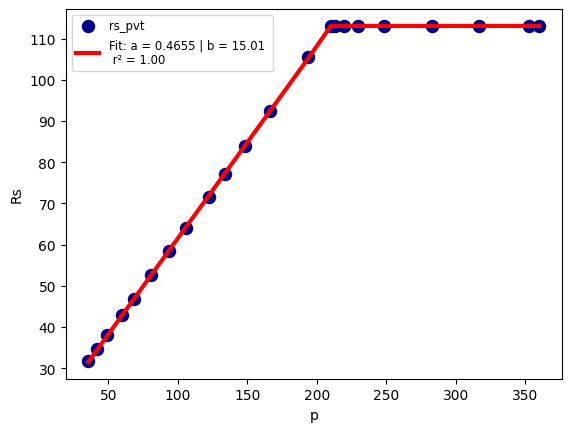

In [8]:
## Ajuste Rs

rs_pvt=pvt_df["Rs"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
rs_adj = rs_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_rsb(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_rsb, p_adj, rs_adj, initialGuess)
rs_a, rs_b = popt[0], popt[1]
print(rs_a, rs_b)

## Função rs
def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          rs[i] = a * p[i] + b
        else:
          rs[i] = Rsi
    return rs

## Valores previstos
rs_prev = func_rs(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(rs_pvt, rs_prev)

## Gráfico comparativo rs x rs_prev
plt.scatter(p_pvt, rs_pvt, label="rs_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, rs_adj, label="rs_adj", color="darkorange", s=75)
plt.plot(p_pvt, rs_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Rs")
plt.show()

-0.6694676522665927 4.524634378080458


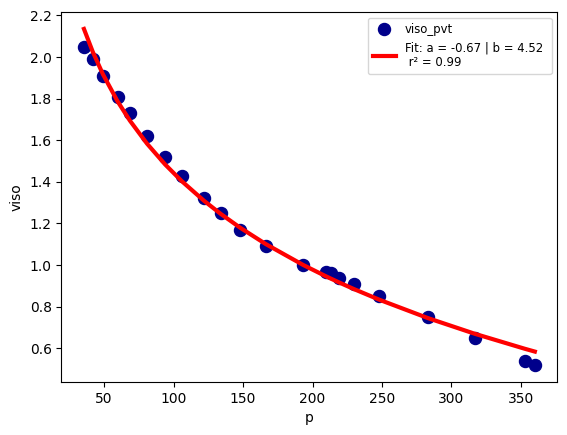

In [9]:
## Ajuste Viso

viso_pvt=pvt_df["viso"].values

## Ajuste de uma reta por mínimos quadrados
def func_viso(p, a, b):
    return a*np.log(p)+b

initialGuess=[-1,1]
popt, pcov = curve_fit(func_viso, p_pvt, viso_pvt, initialGuess)

## Valores previstos
viso_prev = func_viso(p_pvt, *popt)
viso_a, viso_b = popt[0], popt[1]
print(viso_a, viso_b)

## Métrica de desempenho
r2 = r2_score(viso_pvt, viso_prev)

## Gráfico comparativo viso x viso_prev
plt.scatter(p_pvt, viso_pvt, label="viso_pvt", color="darkblue", s=75)
plt.plot(p_pvt, viso_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("viso")
plt.show()

5.532705804609023e-05 0.008974925072326187


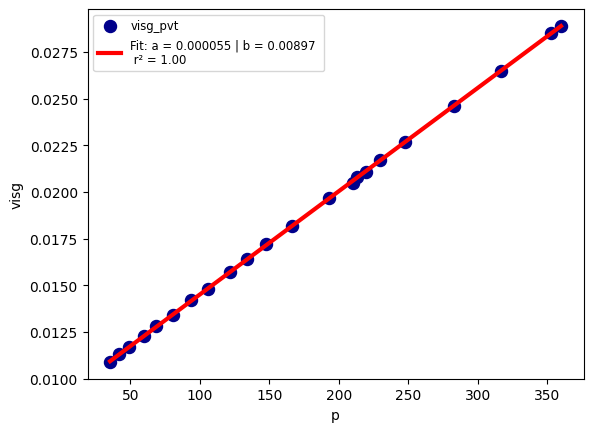

In [10]:
## Ajuste visg

visg_pvt=pvt_df["visg"].values

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_visg(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_visg, p_pvt, visg_pvt, initialGuess)
visg_a, visg_b = popt[0], popt[1]
print(visg_a, visg_b)

## Valores previstos
visg_prev = func_visg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(visg_pvt, visg_prev)

## Gráfico comparativo visg x visg_prev
plt.scatter(p_pvt, visg_pvt, label="visg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, visg_prev, label=f"Fit: a = {popt[0]:0.6f} | b = {popt[1]:0.5f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("visg")
plt.show()

## Ajuste KREL

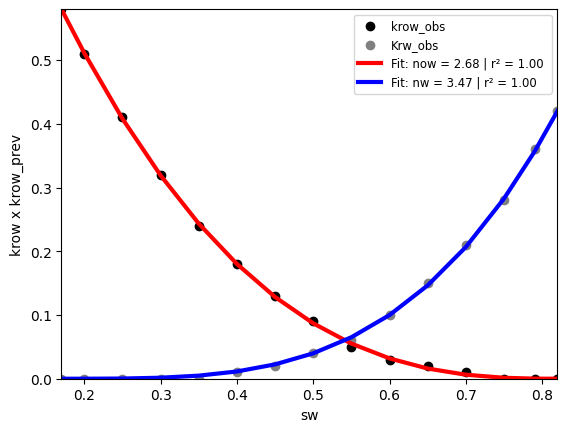

In [11]:
## Permeabilidade Relativa Óleo-Água

krow_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krow")

sw = krow_df["sw"].values
krow_obs = krow_df["krow"].values
krw_obs = krow_df["krw"].values

krow_max = krow_obs[0]
krw_max = krw_obs[-1]

def f_krow(sw, now):
  return krow_max*((1-Sor-sw)/(1-Sor-Swi))**now

def f_krw(sw, nw):
  return krw_max*((sw-Swi)/(1-Sor-Swi))**nw

## Ajuste krow
initialGuess1=[2]
popt1,pcov1 = curve_fit(f_krow, sw, krow_obs, initialGuess1)
krow_pred = f_krow(sw, *popt1)
r2_1 = r2_score(krow_obs, krow_pred)
now = popt1[0]

## Ajuste krw
initialGuess2=[2]
popt2,pcov2 = curve_fit(f_krw, sw, krw_obs, initialGuess2)
krw_pred = f_krw(sw, *popt2)
r2_2 = r2_score(krw_obs, krw_pred)
nw = popt2[0]

plt.scatter(sw, krow_obs, label="krow_obs", color="black")
plt.scatter(sw, krw_obs, label="Krw_obs", color="grey")
plt.plot(sw, krow_pred, label=f"Fit: now = {now:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sw, krw_pred, label=f"Fit: nw = {nw:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sw")
plt.ylabel("krow x krow_prev")
plt.xlim(sw[0], sw[-1])
plt.ylim(0, krow_max)
plt.show()

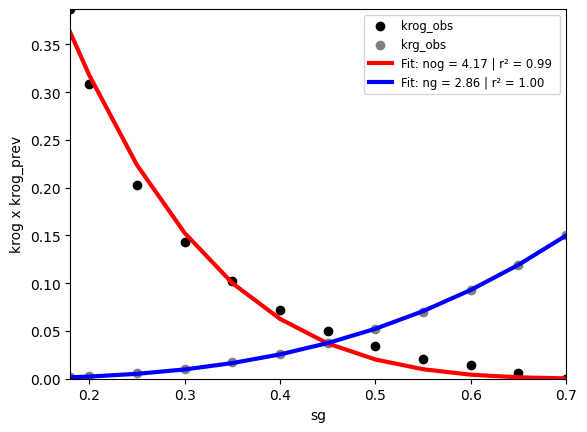

In [12]:
## Permeabilidade Relativa Gás-Óleo

krog_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krog").iloc[1:,]

sg = krog_df["sg"].values
krog_obs = krog_df["krog"].values
krg_obs = krog_df["krg"].values

krog_max = krog_obs[0]
krg_max = krg_obs[-1]

def f_krog(sg, nog):
  return krog_max*((1-Sor-sg)/(1-Sor-Swi))**nog

def f_krg(sg, ng):
  return krg_max*((sg-Sgc)/(1-Sor-Swi))**ng

## Ajuste krog
initialGuess1=[3]
popt1,pcov1 = curve_fit(f_krog, sg, krog_obs, initialGuess1)
krog_pred = f_krog(sg, *popt1)
r2_1 = r2_score(krog_obs, krog_pred)
nog = popt1[0]

## Ajuste krg
initialGuess2=[3]
popt2,pcov2 = curve_fit(f_krg, sg, krg_obs, initialGuess2)
krg_pred = f_krg(sg, *popt2)
r2_2 = r2_score(krg_obs, krg_pred)
ng = popt2[0]

plt.scatter(sg, krog_obs, label="krog_obs", color="black")
plt.scatter(sg, krg_obs, label="krg_obs", color="grey")
plt.plot(sg, krog_pred, label=f"Fit: nog = {nog:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sg, krg_pred, label=f"Fit: ng = {ng:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sg")
plt.ylabel("krog x krog_prev")
plt.xlim(sg[0], sg[-1])
plt.ylim(0, krog_max)
plt.show()

## Módulo de Ajuste de Histórico

### Importação Histórico - Campo

In [13]:
hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:,:]
# hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:49,:]
hist_df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [14]:
hist_df["t"] = (hist_df["Date"]-hist_df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
hist_df["dt"]=hist_df["t"].diff().fillna(0)
hist_df["qo"]=(hist_df["Np"].diff()/hist_df["dt"]).fillna(0)
hist_df["qg"]=(hist_df["Gp"].diff()/hist_df["dt"]).fillna(0)
hist_df["qw"]=(hist_df["Wp"].diff()/hist_df["dt"]).fillna(0)
hist_df["qwi"]=(hist_df["Winj"].diff()/hist_df["dt"]).fillna(0)
# hist_df["p_med"]= (hist_df["Press"]+(hist_df["Press"]-hist_df["Press"].diff()).fillna(hist_df["Press"].iloc[0]))/2
# hist_df["dp"]= hist_df["Press"].iloc[0]-hist_df["Press"]
# hist_df["pmt"]=((hist_df["Press"].iloc[0]-hist_df["p_med"])*hist_df["dt"]).cumsum()
hist_df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0,9053.0,986609.0,6446.0,19374.0
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0,9116.0,1003676.0,6552.0,21068.0
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0,9090.0,1013683.0,6635.0,20900.0
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0,8777.0,997947.0,6738.0,19286.0
132,2024-05-31,309,25832419,2913898931,5206739,39341191,3988.0,31.0,8549.0,973332.0,6933.0,20607.0


In [15]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = hist_df["Press"].values

bo = func_bo(p, bo_a, bo_b)
hist_df["Bo"]=bo

bg = func_bg(p, bg_a, bg_b)
hist_df["Bg"]=bg

rs = func_rs(p, rs_a, rs_b)
hist_df["Rs"]=rs

uo = func_viso(p, viso_a, viso_b)
hist_df["Viso"]=uo

ug = func_visg(p, visg_a, visg_b)
hist_df["Visg"]=ug

hist_df["Rp"] = (hist_df["Gp"]/hist_df["Np"]).fillna(0)

# hist_df["Bt"]=hist_df["Bo"]+(Rsi-hist_df["Rs"])*hist_df["Bg"]
# hist_df["F"] = hist_df["Np"]*(hist_df["Bt"]+(hist_df["Rp"]-Rsi)*hist_df["Bg"])+(hist_df["Wp"]-hist_df["Winj"])*Bw
hist_df["F"] = hist_df["Np"]*(hist_df["Bo"]+(hist_df["Rp"]-hist_df["Rs"])*hist_df["Bg"])+(hist_df["Wp"]-hist_df["Winj"])*Bw
# hist_df["Eo"] = hist_df["Bt"]-hist_df["Bt"].iloc[0]
hist_df["Eo"] = hist_df["Bo"]-hist_df["Bo"].iloc[0]+(hist_df["Rs"].iloc[0]-hist_df["Rs"])*hist_df["Bg"]
# hist_df["Eg"] = hist_df["Bt"].iloc[0]*(hist_df["Bg"]/hist_df["Bg"].iloc[0]-1)
hist_df["Eg"] = hist_df["Bo"].iloc[0]*((hist_df["Bg"]/hist_df["Bg"].iloc[0])-1)
# hist_df["Efw"] = hist_df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(hist_df["Press"].iloc[0]-hist_df["Press"])
hist_df["Efw"] = (1+m)*hist_df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(hist_df["Press"].iloc[0]-hist_df["Press"])

hist_df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,1.394241,0.003249,113.06,0.638284,0.027344,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,1.394403,0.003260,113.06,0.640304,0.027288,110.724725,85895.010882,0.000162,0.004455,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,1.394727,0.003281,113.06,0.644361,0.027178,108.777224,171760.217854,0.000486,0.013447,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,1.394889,0.003291,113.06,0.646399,0.027122,110.251684,252773.623635,0.000648,0.017986,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,1.395051,0.003302,113.06,0.648443,0.027067,109.683370,338857.869258,0.000810,0.022553,0.000513


### Ajuste de Histórico

In [16]:
train_df = hist_df.copy()
train_df = train_df.drop(["Date", "F", "Eo", "Eg", "Efw", "dt", "qo", "qg", "qw", "qwi", "Rp"], axis=1)
train_df.rename(columns={'Press': 'p'}, inplace=True)
train_df = train_df[['t', 'Np', 'Gp', 'Wp', 'Winj', 'Bo', 'Bg', 'Rs', 'Viso', 'Visg', 'p']]

train_df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
1,0.0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
2,31.0,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
3,62.0,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
4,92.0,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
5,123.0,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [17]:
# Exporta o DataFrame para um arquivo Excel
# train_df.to_excel('dataset_unisim.xlsx', index=False)
train_df.shape

(132, 11)

In [18]:
## Importação do histórico - UNISIM - vazões
df2 = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim_rate.xlsx')
df2.head()

,t,qo,qg,qw,qwinj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,1998,221228,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,2015,215295,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,1934,219341,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,2014,217558,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [19]:
df2.index = df2['t']
# df2.drop(df.columns[:5], axis=1, inplace=True)
df2.drop('t', axis=1, inplace=True)
df2.drop('Rs', axis=1, inplace=True)
df2.drop('Viso', axis=1, inplace=True)
df2.drop('Visg', axis=1, inplace=True)
df2.head()

,qo,qg,qw,qwinj,Bo,Bg,p
t,,,,,,,
0,0,0,0,0,1.394241,0.003249,332
31,1998,221228,0,0,1.394403,0.003260,331
62,2015,215295,0,0,1.394727,0.003281,329
92,1934,219341,0,0,1.394889,0.003291,328
123,2014,217558,0,0,1.395051,0.003302,327


In [20]:
df2["p_ant"]=df2["p"].shift(1).fillna(train_df["p"].values[0])
df2.drop('p', axis=1, inplace=True)
df2["p"]=train_df["p"].values
df2.tail()

,qo,qg,qw,qwinj,Bo,Bg,p_ant,p
t,,,,,,,,
3867,9053,986609,6446,19374,1.398615,0.003554,304.0,305
3896,9116,1003676,6552,21068,1.398453,0.003542,305.0,306
3927,9090,1013683,6635,20900,1.398291,0.003530,306.0,307
3957,8777,997947,6738,19286,1.398129,0.003518,307.0,308
3988,8549,973332,6933,20607,1.397967,0.003506,308.0,309


In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Separar as características e o rótulo
features = np.array(df2.iloc[:, :-1])  # Todas as colunas exceto a última
# features = df2.iloc[:, 1:-1]  # Todas as colunas menos a última e a primeira (t)
labels = df2.iloc[:, -1]     # Última coluna

# Normalizar as características
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# # Valores Máximos e Mínimos
# bo_max = bo_pvt.max()
# bg_max = bg_pvt.max()
# qo_max = 16000
# qg_max = 2000000
# qw_max = 15000
# qwi_max = 25000

# qo_min, qg_min, qw_min, qwi_min = 0, 0, 0, 0
# bo_min, bg_min = 0, 0

# p_max = 400.00
# p_min = 0.00

# # Normalizando os valores
# scaled_features = np.zeros(features.shape)
# scaled_features[:,0] = (features[:,0] - qo_min) / (qo_max - qo_min)
# scaled_features[:,1] = (features[:,1] - qg_min) / (qg_max - qg_min)
# scaled_features[:,2] = (features[:,2] - qw_min) / (qw_max - qw_min)
# scaled_features[:,3] = (features[:,3] - qwi_min) / (qwi_max - qwi_min)
# scaled_features[:,4] = (features[:,4] - bo_min) / (bo_max - bo_min)
# scaled_features[:,5] = (features[:,5] - bg_min) / (bg_max - bg_min)
# scaled_features[:,6] = (features[:,6] - p_min) / (p_max - p_min)

# Combinar as características normalizadas e a coluna de rótulos não normalizada
scaled_data = np.concatenate([scaled_features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = np.concatenate([features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = df2.to_numpy()

scaled_data.shape, scaled_data[0], labels

((132, 8),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   1., 332.]),
 t
 0       332
 31      331
 62      329
 92      328
 123     327
        ... 
 3867    305
 3896    306
 3927    307
 3957    308
 3988    309
 Name: p, Length: 132, dtype: int64)

In [22]:
# Dicionários para armazenar X e y para cada valor de window_size
datasets = {}

# Gerar os datasets X e y para cada valor de window_size de 1 a 6
for window_size in range(1, 7):
    X = []
    y = []
    for i in range(len(scaled_data) - window_size):
        seq = scaled_data[i:i + window_size][:, :-1]
        label = scaled_data[i + window_size - 1][-1]
        X.append(seq)
        y.append(label)

    # Convertendo para arrays do JAX e armazenando no dicionário
    datasets[window_size] = {
        'X': jnp.array(X),
        'y': jnp.array(y)
    }

In [23]:
window_size = 1  # Número de timesteps em cada sequencia
# features_count = len(df2.columns) # p é considerado como característica
# features_count = len(df2.columns) - 1 # p não é considerado como característica

# Criando as sequências e os rótulos correspondentes
# X = []
# y = []
# for i in range(len(scaled_data) - window_size):
#     seq = scaled_data[i:i+window_size][:,:-1]
#     label = scaled_data[i+window_size-1][-1]
#     X.append(seq)
#     y.append(label)

# window_size, features_count

X = datasets[window_size]['X']
y = datasets[window_size]['y']
X.shape, y.shape

((131, 1, 7), (131,))

In [24]:
# Convert to jax numpy arrays
# X = jnp.array(X)
# y = jnp.array(y)
# X.shape, y.shape

In [25]:
X[0], y[0]

(Array([[0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 Array(332., dtype=float32))

In [26]:
# train_size = len(X) - 24
# train_size = len(X)
# train_size = int(0.5 * len(X))
# val_size = train_size
test_size = 24
val_size = 12
train_size = len(X) - test_size - val_size
# test_size = len(X) - train_size - val_size
# test_size = len(X) - train_size
# test_size = train_size
train_size, val_size, test_size

(95, 12, 24)

In [27]:
X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X_train, y_train
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
# X_test, y_test = X[train_size:], y[train_size:]
# X_val, y_val  = X_test, y_test
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
# X_train, X_val, X_test = X, X, X
# y_train, y_val, y_test = y, y, y

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((95, 1, 7), (95,), (12, 1, 7), (12,), (24, 1, 7), (24,))

In [28]:
X_train[0], y_train[0]

(Array([[0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 Array(332., dtype=float32))

In [29]:
npp=train_df["Np"].values[window_size:train_size+window_size]
gp=train_df["Gp"].values[window_size:train_size+window_size]/1000
wp=train_df["Wp"].values[window_size:train_size+window_size]
winj=train_df["Winj"].values[window_size:train_size+window_size]
bo=train_df["Bo"].values[window_size:train_size+window_size]
bg=train_df["Bg"].values[window_size:train_size+window_size]
rs=train_df["Rs"].values[window_size:train_size+window_size]
viso=train_df["Viso"].values[window_size:train_size+window_size]
visg=train_df["Visg"].values[window_size:train_size+window_size]
p=train_df["p"].values[window_size:train_size+window_size]
t=train_df['t'].values[window_size:train_size+window_size]

# t=train_df["t"].values
# npp=train_df["Np"].values
# gp=train_df["Gp"].values
# gp_m=gp/1000
# wp=train_df["Wp"].values
# winj=train_df["Winj"].values
# bo=train_df["Bo"].values
# bg=train_df["Bg"].values
# rs=train_df["Rs"].values
# viso=train_df["Viso"].values
# visg=train_df["Visg"].values
# p=train_df["p"].values

In [30]:
p.shape, y_train.shape

((95,), (95,))

In [31]:
t0 = train_df['t'].values[0]
p0 = train_df["p"].values[0]
Rsi = train_df["Rs"].values[0]
boi = train_df["Bo"].values[0]
bgi = train_df["Bg"].values[0]

t0, p0, Rsi, boi, bgi

(0.0, 332, 113.06, 1.39424086, 0.0032494770457439813)

In [32]:
# Definir a rede CNN 1D usando Flax
class CNN1D(nn.Module):
    @nn.compact
    def __call__(self, x):

        n_steps = x[0].shape[0]

        # Aplicar a primeira camada Conv1D
        x = nn.Conv(features=8, kernel_size=(n_steps,), strides=(1,))(x)
        x = nn.relu(x)

        # Aplicar a segunda camada Conv1D
        x = nn.Conv(features=8, kernel_size=(n_steps,), strides=(1,))(x)
        x = nn.relu(x)

        # Pooling global (reduz a dimensão temporal)
        x = jnp.mean(x, axis=1)

        # Camada densa
        x = nn.Dense(features=8)(x)
        x = nn.relu(x)

        # Densa final para a saída
        x = nn.Dense(features=1)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class CNNnet(CNN1D):
    def setup(self):
        super().setup()
        self.N = self.param("N", jax.nn.initializers.constant(180.0), ())
        self.Wi = self.param("Wi", jax.nn.initializers.constant(100.0), ())
        self.J = self.param("J", jax.nn.initializers.constant(95.0), ())

# Define the Neural Network
model = CNNnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)  # Assumindo que X_train já está definido
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# lr = 0.01
lr = optax.exponential_decay(init_value=1e-3,
                             transition_steps=3000,
                             decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    params=params,
    tx=tx)

# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                              CNNnet Summary                               
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNNnet │ float32[1,7] │ float32[1]   │ J: float32[]           │
│         │        │              │              │ N: float32[]           │
│         │        │              │              │ Wi: float32[]          │
│         │        │              │              │                        │
│         │        │              │              │ 3 (12 B)               │
├─────────┼────────┼──────────────┼──────────────┼────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,7] │ float32[1,8] │ bias: float32[8]       │
│         │        │              │              │ kernel: float32[7,7,8] │
│         │        │              │              │                        │
│         │

In [33]:
# Imprimindo os parametros a serem ajustados
state.params['params']['N'], state.params['params']['Wi'], state.params['params']['J']

(Array(180., dtype=float32),
 Array(100., dtype=float32),
 Array(95., dtype=float32))

The solution for u(x=[[0. 0. 0. 0. 0. 0. 1.]] = -0.008522864431142807


Text(0.5, 1.0, 'Previsão antes do ajuste do modelo')

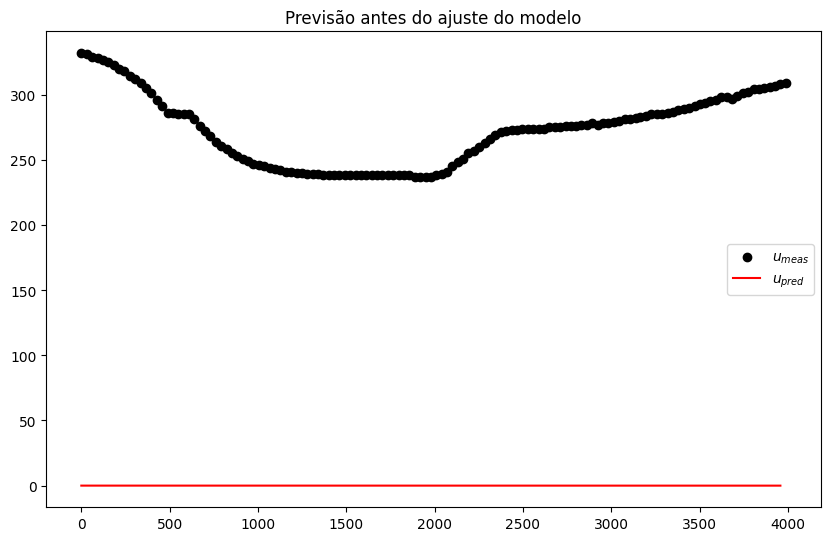

In [34]:
# Avaliando o modelo para um único vetor de entrada
x_single = X_train[0]
u_pred = state.apply_fn(params, x_single)
print(f"The solution for u(x={x_single} = {u_pred}")

# Avaliando a rede neural antes do treinamento considerando todo o histórico
u_pred = vmap(state.apply_fn, (None, 0))(state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(train_df['t'].values, train_df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(train_df["t"].values[:-window_size], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão antes do ajuste do modelo')

In [35]:
# Definir loss function
@jit
def train_step(state, batch):
    def phy_residual_fn(params, u):
        # Aplicar limites nos parâmetros
        N = jnp.clip(params['params']['N'], 0.0, 300.0)  # Limita N entre 0 e 300
        Wi = jnp.clip(params['params']['Wi'], 100.0, 1000.0)  # Limita Wi entre 100 e 1000
        J = jnp.clip(params['params']['J'], 1.0, 100.0)  # Limita J entre 1 e 100

        #EBM
        rp = gp  / jnp.where(npp != 0, npp, 1.0) * 1000
        F = npp * (bo + (rp-rs) * bg) + (wp - winj) * Bw
        Eo = bo - boi + (Rsi - rs) * bg
        Eg = boi * ((bg / bgi) - 1)
        Efw = (1 + m) * boi * ((cf + cw * Swi)/(1 - Swi)) * (p0 - u)
        We_EBM = F - (N * 10**6) * (Eo + m * Eg + Efw)

        #Aquif
        Wei = (cf + cw) * Wi * p0 * 10**6
        Wen = jnp.zeros(len(t))
        dt = jnp.diff(t)
        dt = jnp.insert(dt, 0, t[0])
        pa_med = jnp.zeros(len(t))
        pa_med = pa_med.at[0].set(p0)
        for i in range(1,len(t)):
          pa_med = pa_med.at[i-1].set(p0 *(1 - (Wen[i-1] / Wei)))
          Wen = Wen.at[i].set(Wen[i-1] + (Wei / p0) * (pa_med[i-1] - u[i]) * (1 - jnp.exp(-J * p0 * dt[i] / Wei)))

        res = (We_EBM - Wen) / 10**6
        # res = 0.0
        return res

    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        res_pred = phy_residual_fn(params, u_pred)
        phy_loss = jnp.mean(res_pred ** 2) ** 0.5
        data_loss = jnp.mean(jnp.square(u_pred - batch['u']))
        total_loss = 10.0 * data_loss + 1.0 * phy_loss
        return total_loss, {
            "total_loss": total_loss,
            "data_loss": data_loss,
            "phy_loss": phy_loss,
        }

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(
        state.params, batch
    )
    state = state.apply_gradients(grads=grads)
    return loss_components, state

# Definir evaluation function
@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [36]:
## TREINAMENTO ##

# Criar logs de treinamento
total_loss_log = []
data_loss_log = []
phy_loss_log = []
epoch_log = []
error_log = []
N_log = []
Wi_log = []
J_log = []

# Criar batches de treinamento e validação
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

# Criar variável para armazenar o menor erro de validação e o estado correspondente
best_error = float('inf')
best_state = None

# Executar o treinamento da rede neural
epochs = 50_000

for epoch in range(epochs):
  loss, state = train_step(state, train_batch)
  if epoch%1000 == 0:
    epoch_log.append(epoch)
    N_est = state.params["params"]["N"]
    Wi_est = state.params["params"]["Wi"]
    J_est = state.params["params"]["J"]
    total_loss_log.append(loss['total_loss'])
    data_loss_log.append(loss['data_loss'])
    phy_loss_log.append(loss['phy_loss'])
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    N_log.append(N_est)
    Wi_log.append(Wi_est)
    J_log.append(J_est)
    print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.6f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

    # Salvar o estado do modelo com menor erro
    if (epoch > 10_000) and (eval_error < best_error):
        best_error = eval_error
        best_state = state

Epoch: 0 -- Total Loss: 712405.500000  -- Data Loss: 71239.812500 -- Physics Loss: 7.384701 -- Error: 78697.992188 -- N: 180.00 -- Wi: 100.00 -- J: 95.00
Epoch: 1000 -- Total Loss: 42515.457031  -- Data Loss: 4251.383301 -- Physics Loss: 1.630044 -- Error: 3868.843750 -- N: 179.21 -- Wi: 99.99 -- J: 94.04
Epoch: 2000 -- Total Loss: 7497.185059  -- Data Loss: 749.645752 -- Physics Loss: 0.727519 -- Error: 126.243454 -- N: 179.22 -- Wi: 99.99 -- J: 93.24
Epoch: 3000 -- Total Loss: 577.911865  -- Data Loss: 57.759037 -- Physics Loss: 0.321562 -- Error: 42.445309 -- N: 179.82 -- Wi: 99.99 -- J: 93.06
Epoch: 4000 -- Total Loss: 246.591431  -- Data Loss: 24.631432 -- Physics Loss: 0.277133 -- Error: 54.004616 -- N: 180.58 -- Wi: 99.99 -- J: 93.58
Epoch: 5000 -- Total Loss: 97.657249  -- Data Loss: 9.740766 -- Physics Loss: 0.249597 -- Error: 43.696686 -- N: 181.41 -- Wi: 99.99 -- J: 94.32
Epoch: 6000 -- Total Loss: 28.817539  -- Data Loss: 2.858654 -- Physics Loss: 0.230997 -- Error: 23.4525

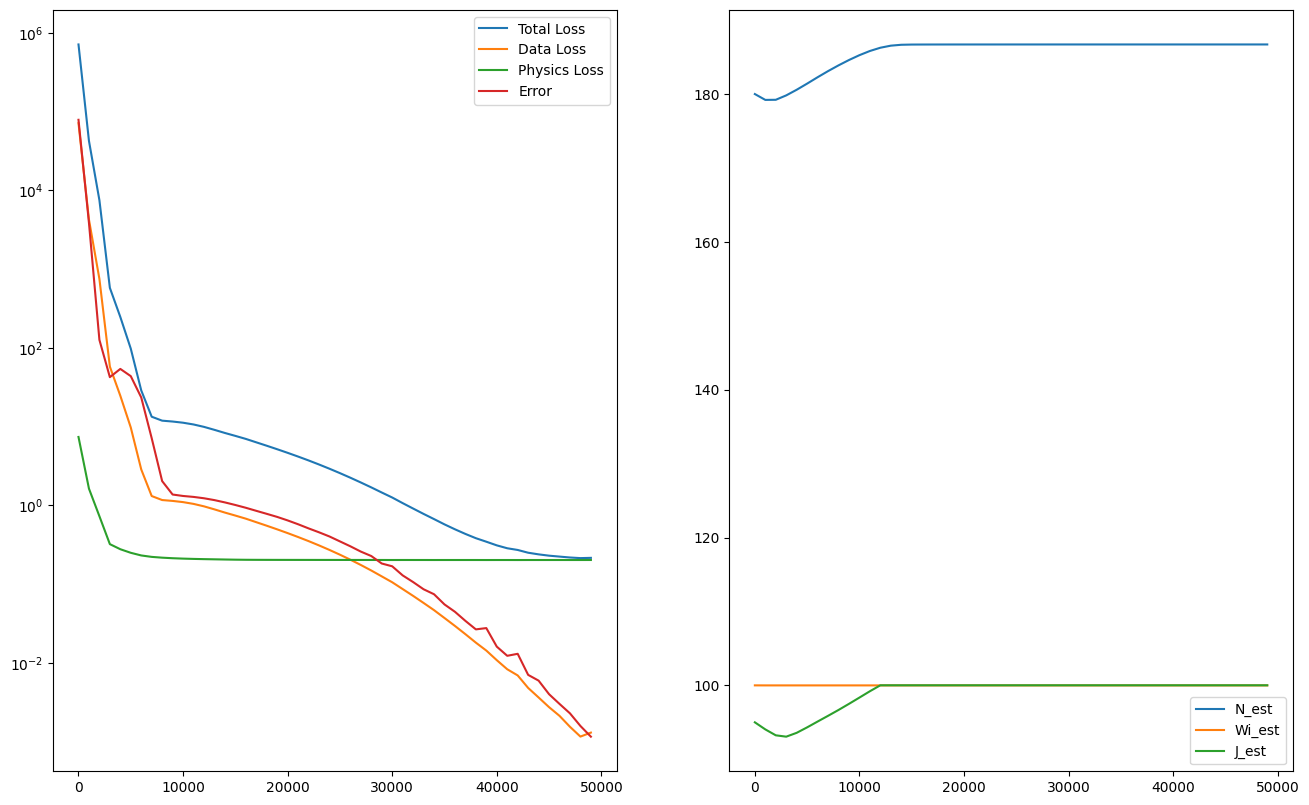

In [37]:
# Plot training & validation loss values
fig, axs = plt.subplots(1, 2, figsize=(16, 16 / 1.618))

axs[0].plot(epoch_log, total_loss_log, label="Total Loss")
axs[0].plot(epoch_log, data_loss_log, label="Data Loss")
axs[0].plot(epoch_log, phy_loss_log, label="Physics Loss")
axs[0].plot(epoch_log, error_log, label="Error")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(epoch_log, N_log, label="N_est")
axs[1].plot(epoch_log, Wi_log, label="Wi_est")
axs[1].plot(epoch_log, J_log, label="J_est")
axs[1].legend()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict using the trained model
predictions = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.0269139613956213
Mean Squared Error (MSE): 0.001099107787013054
Root Mean Squared Error (RMSE): 0.03315279455812215


Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

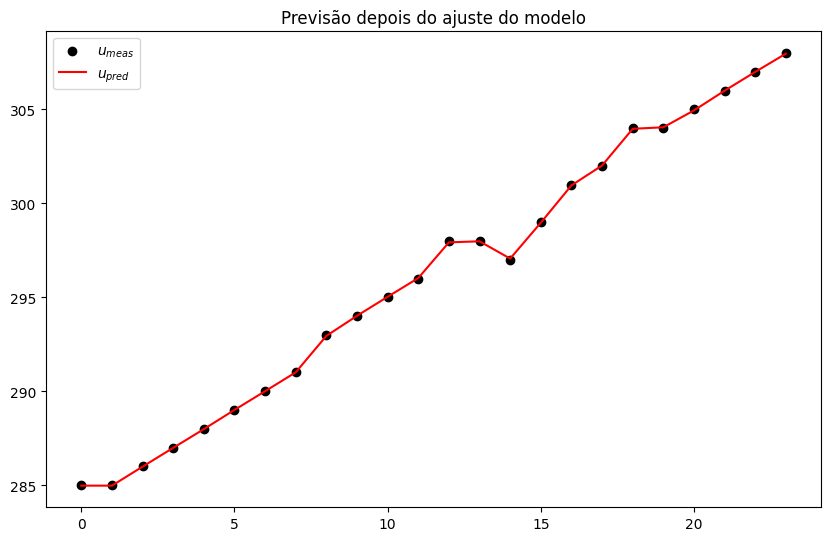

In [39]:
# Avaliando a rede neural depois do treinamento considerando o teste

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(jnp.arange(0, len(y_test), 1), y_test, label=r'$u_{meas}$', color='black')
ax.plot(jnp.arange(0, len(y_test), 1), predictions, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')

Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

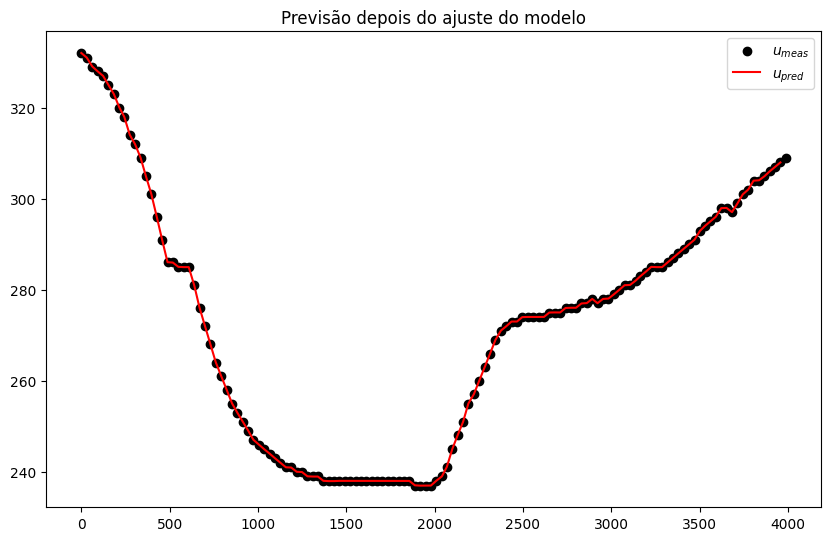

In [40]:
# Avaliando a rede neural depois do treinamento considerando todo o histórico
u_pred = vmap(best_state.apply_fn, (None, 0))(best_state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(train_df['t'].values, train_df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(train_df["t"].values[:-window_size], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')

In [41]:
# Imprimindo os parametros ajustados
N_est = best_state.params["params"]["N"].item()
Wi_est = best_state.params["params"]["Wi"].item()
J_est = best_state.params["params"]["J"].item()

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Estimativa de N: 186.71
Estimativa de Wi: 99.99
Estimativas de J: 100.01


In [42]:
p=hist_df["Press"].values
# p_med=hist_df["p_med"].values
t=hist_df["t"].values
dt=hist_df["dt"].values
F=hist_df["F"].values
Eo=hist_df["Eo"].values
Eg=hist_df["Eg"].values
Efw=hist_df["Efw"].values
npp=hist_df["Np"].values
gp=hist_df["Gp"].values
rp=hist_df["Rp"].values
wp=hist_df["Wp"].values
winj=hist_df["Winj"].values
qo=hist_df["qo"].values
qg=hist_df["qg"].values
qw=hist_df["qw"].values
qwi=hist_df["qwi"].values
bo=hist_df["Bo"].values
bg=hist_df["Bg"].values
rs=hist_df["Rs"].values
uo=hist_df["Viso"].values
ug=hist_df["Visg"].values

desvio (MMm³): 0.2115
r²: 0.70


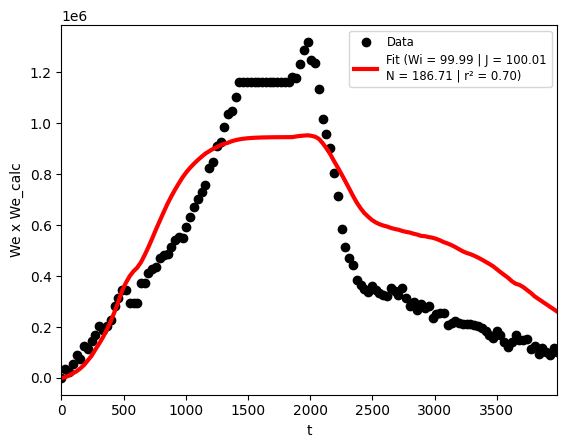

In [43]:
#EBM
dt = np.diff(t)
dt = np.insert(dt, 0, 0.0)
rp = gp / np.where(npp != 0, npp, 1.0)

F = npp * (bo + (rp-rs) * bg) + (wp - winj) * Bw
Eo = bo - bo[0] + (Rsi - rs) * bg
Eg = bo[0] * ((bg / bg[0]) - 1)
Efw = (1 + m) * bo[0] * ((cf + cw * Swi)/(1 - Swi)) * (p[0] - p)
We_EBM = F - (N_est * 10**6) * (Eo + m * Eg + Efw)

#Aquif
Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(f"desvio (MMm³): {np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5:0.4f}")

r2_2 = r2_score(We_EBM, Wen)
print(f"r²: {r2_2:0.2f}")

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

In [44]:
df2

,qo,qg,qw,qwinj,Bo,Bg,p_ant,p
t,,,,,,,,
0,0,0,0,0,1.394241,0.003249,332.0,332
31,1998,221228,0,0,1.394403,0.003260,332.0,331
62,2015,215295,0,0,1.394727,0.003281,331.0,329
92,1934,219341,0,0,1.394889,0.003291,329.0,328
123,2014,217558,0,0,1.395051,0.003302,328.0,327
...,...,...,...,...,...,...,...,...
3867,9053,986609,6446,19374,1.398615,0.003554,304.0,305
3896,9116,1003676,6552,21068,1.398453,0.003542,305.0,306
3927,9090,1013683,6635,20900,1.398291,0.003530,306.0,307


### Previsao de pressao

309.0091


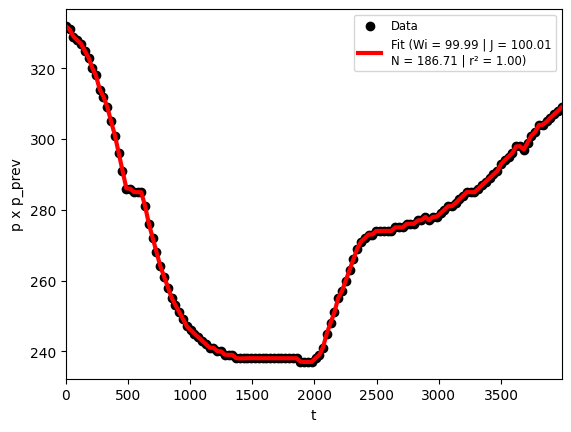

In [45]:
## Previsao de pressao

X_fc = X.copy()
# print(X_fc.shape)
new_vector = df2.iloc[-1, :-1].values.reshape(1,-1)

# Normalizar o new_vector usando o mesmo scaler aplicado às características originais
new_vector = scaler.transform(new_vector)
# print(new_vector)
new_vector = new_vector.reshape((1, new_vector.shape[0], new_vector.shape[1]))
# print(new_vector.shape)

# Adicionar ao X_fc
X_fc = jnp.concatenate([X_fc, new_vector], axis=0)
# print(X_fc.shape)

# Normalizando
# new_vector[:,0] = (new_vector[:,0] - qo_min) / (qo_max - qo_min)
# new_vector[:,1] = (new_vector[:,1] - qg_min) / (qg_max - qg_min)
# new_vector[:,2] = (new_vector[:,2] - qw_min) / (qw_max - qw_min)
# new_vector[:,3] = (new_vector[:,3] - qwi_min) / (qwi_max - qwi_min)
# new_vector[:,4] = (new_vector[:,4] - bo_min) / (bo_max - bo_min)
# new_vector[:,5] = (new_vector[:,5] - bg_min) / (bg_max - bg_min)
# new_vector[:,6] = (new_vector[:,6] - p_min) / (p_max - p_min)
# new_vector = jnp.array(new_vector)

# new_vector = jnp.array(scaler.transform((df2.iloc[-1, :-1].values.reshape(1,-1))))
# new_vector = jnp.array(df2.iloc[-1, :-1].values.reshape(1,-1)/max_scaler)
# new_vector = new_vector.reshape((1, new_vector.shape[0], new_vector.shape[1]))
# X_fc = jnp.concatenate([X_fc, new_vector], axis=0)
# print(X_fc.shape)

p_prev = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_fc)
print(p_prev[-1])
ppa_med = pa_med

r2_2 = r2_score(p, p_prev)
# print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
# plt.plot(t, ppa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

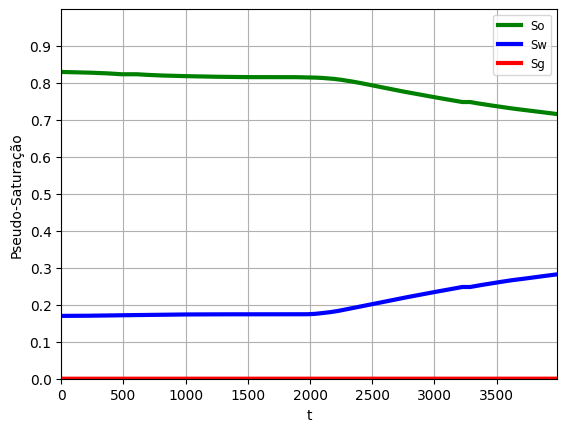

In [46]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

### Importação Histórico - Poço

In [47]:
## Importação do histórico por poço
wells_hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist_well-m.xlsx')
wells_hist_df.head()

,well,Date,BHP,Np,Gp,Wp,Winj
0,NA1A,2013-06-30,324,0,0,0,0
1,NA1A,2013-07-31,256,61938,6858068,0,0
2,NA1A,2013-08-31,262,124403,13532213,0,0
3,NA1A,2013-09-30,248,182423,20112443,0,0
4,NA1A,2013-10-31,249,244857,26856741,0,0


In [48]:
wells = wells_hist_df["well"].drop_duplicates().values.astype(str)
wells_prod = wells[~np.char.startswith(wells, 'INJ')]
wells_inj = wells[np.char.startswith(wells, 'INJ')]

wells_prod, wells_inj

(array(['NA1A', 'NA2', 'NA3D', 'RJS19', 'PROD005', 'PROD008', 'PROD009',
        'PROD010', 'PROD012', 'PROD014', 'PROD021', 'PROD023A', 'PROD024A',
        'PROD025A'], dtype='<U8'),
 array(['INJ003', 'INJ005', 'INJ006', 'INJ007', 'INJ010', 'INJ015',
        'INJ017', 'INJ019', 'INJ021', 'INJ022', 'INJ023'], dtype='<U8'))

In [49]:
len(wells_prod), len(wells_inj)

(14, 11)

In [50]:
wells_prod_hist_df = []

for i in range(len(wells_prod)):
  wells_prod_hist_df.append(wells_hist_df[wells_hist_df['well'] == wells_prod[i]].copy())
  wells_prod_hist_df[i]["t"]=(wells_prod_hist_df[i]["Date"]-wells_prod_hist_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_hist_df[i]["dt"]=wells_prod_hist_df[i]["t"].diff().fillna(0)
  wells_prod_hist_df[i]["qo"]=(wells_prod_hist_df[i]["Np"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qg"]=(wells_prod_hist_df[i]["Gp"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qw"]=(wells_prod_hist_df[i]["Wp"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qwi"]=(wells_prod_hist_df[i]["Winj"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  # wells_prod_hist_df[i]["qb"]=wells_prod_hist_df[i]["qo"]+wells_prod_hist_df[i]["qw"]
  wells_prod_hist_df[i]["RAO"]=(wells_prod_hist_df[i]["qw"]/wells_prod_hist_df[i]["qo"]).fillna(1E-6)
  # wells_prod_hist_df[i]["RGO"]=(wells_prod_hist_df[i]["qg"]/wells_prod_hist_df[i]["qo"]).fillna(0)

wells_prod_hist_df[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
0,NA1A,2013-06-30,324,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001
1,NA1A,2013-07-31,256,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,0.0,0.0,0.000000
2,NA1A,2013-08-31,262,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,0.0,0.0,0.000000
3,NA1A,2013-09-30,248,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,0.0,0.0,0.000000
4,NA1A,2013-10-31,249,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NA1A,2024-01-31,223,4352533,491925193,330103,0,3867.0,31.0,1488.0,161964.0,494.0,0.0,0.331989
128,NA1A,2024-02-29,229,4396062,496554028,346517,0,3896.0,29.0,1501.0,159615.0,566.0,0.0,0.377082
129,NA1A,2024-03-31,237,4442283,501390152,364125,0,3927.0,31.0,1491.0,156004.0,568.0,0.0,0.380952
130,NA1A,2024-04-30,230,4482903,506082482,381495,0,3957.0,30.0,1354.0,156411.0,579.0,0.0,0.427622


In [51]:
wells_inj_hist_df = []

for i in range(len(wells_inj)):
  wells_inj_hist_df.append(wells_hist_df[wells_hist_df['well'] == wells_inj[i]].copy())
  wells_inj_hist_df[i]["t"]=(wells_inj_hist_df[i]["Date"]-wells_inj_hist_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_hist_df[i]["dt"]=wells_inj_hist_df[i]["t"].diff().fillna(0)
  wells_inj_hist_df[i]["qo"]=(wells_inj_hist_df[i]["Np"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qg"]=(wells_inj_hist_df[i]["Gp"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qw"]=(wells_inj_hist_df[i]["Wp"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qwi"]=(wells_inj_hist_df[i]["Winj"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)

wells_inj_hist_df[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
1848,INJ003,2013-06-30,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1849,INJ003,2013-07-31,0,0,0,0,0,31.0,31.0,0.0,0.0,0.0,0.0
1850,INJ003,2013-08-31,0,0,0,0,0,62.0,31.0,0.0,0.0,0.0,0.0
1851,INJ003,2013-09-30,0,0,0,0,0,92.0,30.0,0.0,0.0,0.0,0.0
1852,INJ003,2013-10-31,0,0,0,0,0,123.0,31.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,INJ003,2024-01-31,347,0,0,0,5615925,3867.0,31.0,0.0,0.0,0.0,2697.0
1976,INJ003,2024-02-29,352,0,0,0,5691325,3896.0,29.0,0.0,0.0,0.0,2600.0
1977,INJ003,2024-03-31,349,0,0,0,5766996,3927.0,31.0,0.0,0.0,0.0,2441.0
1978,INJ003,2024-04-30,347,0,0,0,5846406,3957.0,30.0,0.0,0.0,0.0,2647.0


### Ajuste logRAOxNp

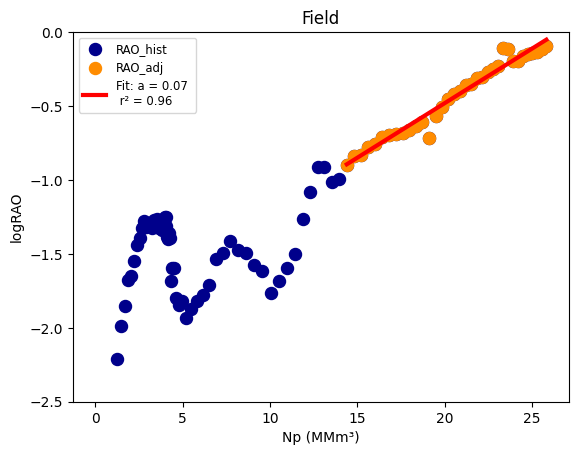

In [52]:
## Ajuste LogRAOxNp - Campo

RAO = np.zeros(len(t))
for i in range(len(t)):
  if qo[i] == 0 or qw[i] == 0:
    RAO[i]=1E-6
  else:
    RAO[i]=qw[i]/qo[i]

## Escolhendo intervalo e retirando outliers para o ajuste
RAO_adj = RAO[(npp>1.4E7) & (np.log10(RAO)>-6)]
npp_adj = npp[(npp>1.4E7) & (np.log10(RAO)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(npp_adj, np.log10(RAO_adj), 1)
a = coeficientes[0]
b = coeficientes[1]

# Valores previstos
logRAO_prev = a*npp_adj + b

# Métrica de desempenho
r2 = r2_score(np.log10(RAO_adj), logRAO_prev)

plt.scatter(npp/10**6, np.log10(RAO), label="RAO_hist", color="darkblue", s=75)
plt.scatter(npp_adj/10**6, np.log10(RAO_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(npp_adj/10**6, logRAO_prev, label=f"Fit: a = {a*10**6:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title("Field")
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

In [53]:
hist_df["P_prev"]=p_prev
hist_df["So"]=So
hist_df["Sw"]=Sw
hist_df["Sg" ]=Sg
hist_df["We_ebm"]=We_EBM
hist_df["We_aqui"]=Wen
hist_df["Pa_med"]=ppa_med
hist_df["cct"]=cct
hist_df["Vpp"]=Vpp
hist_df["RAO"]=RAO

hist_df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,332.004700,0.830000,0.170000,0.000000,0.000000,0.000000,332.000000,1.000000,3.136351e+08,0.000001
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,330.990387,0.829769,0.170026,0.000002,36487.572191,2668.032900,331.734772,0.999937,3.136185e+08,0.000001
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,329.047516,0.829579,0.170084,0.000006,23537.901781,9964.494882,331.009434,0.999812,3.135853e+08,0.000001
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,327.991974,0.829365,0.170126,0.000005,55143.868871,17771.518648,330.233342,0.999749,3.135687e+08,0.000001
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,326.982758,0.829131,0.170171,0.000009,91820.675803,26398.180889,329.375769,0.999686,3.135520e+08,0.000001


In [54]:
## Inicialização dos parâmetros dos poços

aw = np.zeros(len(wells_prod))
bw = np.zeros(len(wells_prod))
BHPP = np.zeros(len(wells_prod))
BHPI = np.zeros(len(wells_inj))
IP = np.zeros(len(wells_prod))
II = np.zeros(len(wells_inj))

0.4875870040077862


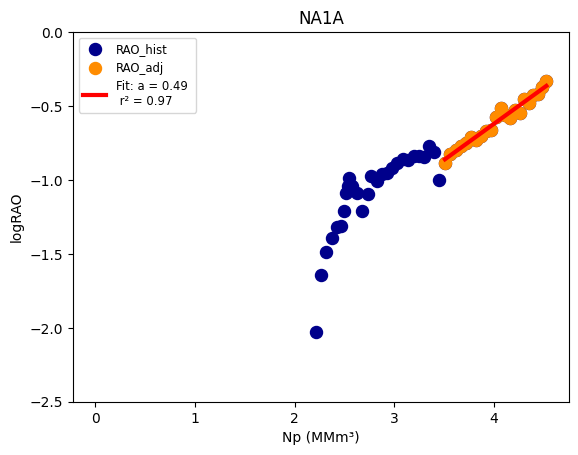

In [55]:
## Ajuste LogRAOxNp - Well 0

w_num = 0

qow = wells_prod_hist_df[0]["qo"].values
qww = wells_prod_hist_df[0]["qw"].values
nppw = wells_prod_hist_df[0]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 3.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

1.4702945444976585


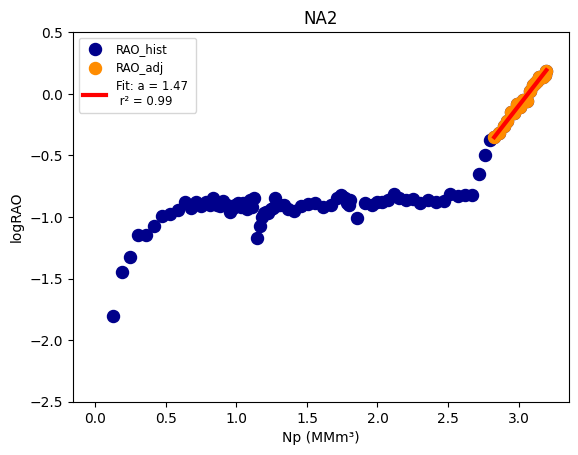

In [56]:
## Ajuste LogRAOxNp - Well 1

w_num = 1

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.8395962379108004


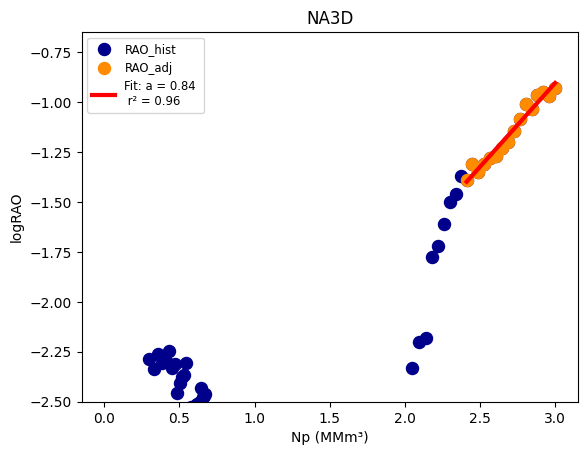

In [57]:
## Ajuste LogRAOxNp - Well 2

w_num = 2

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.4
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0737554062527863


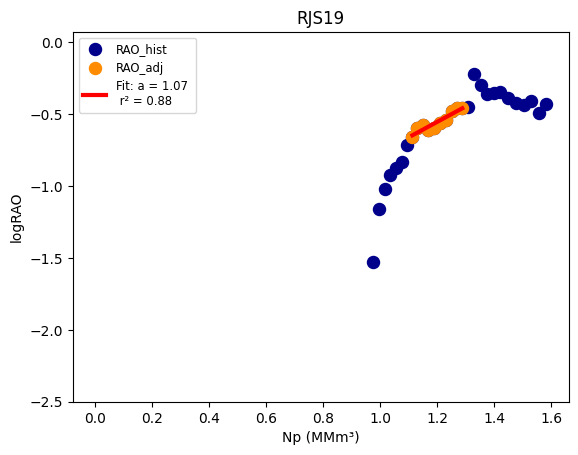

In [58]:
## Ajuste LogRAOxNp - Well 3

w_num = 3

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.1
npp_max = 1.3
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# # Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# # Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0300059658867038


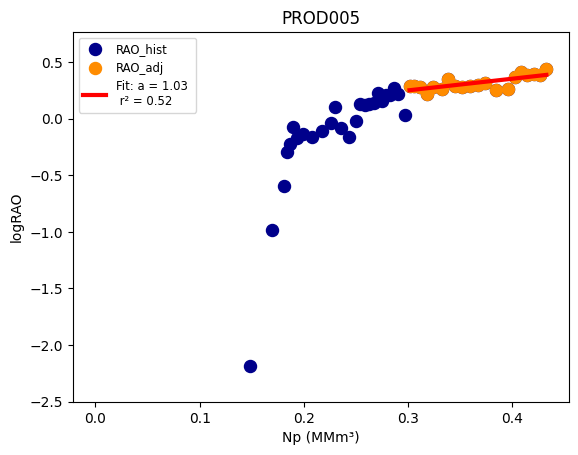

In [59]:
## Ajuste LogRAOxNp - Well 4

w_num = 4

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.3
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2954635228358724


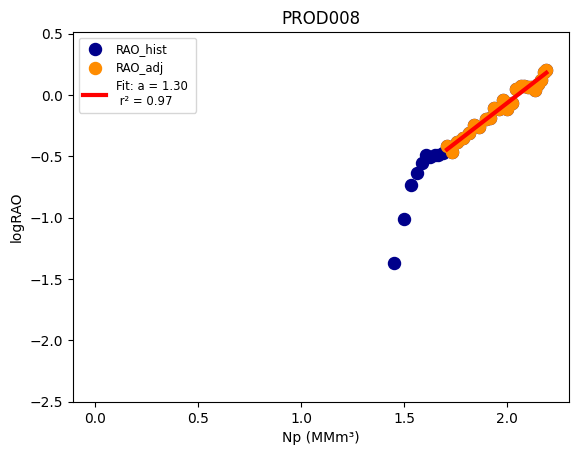

In [60]:
## Ajuste LogRAOxNp - Well 5

w_num = 5

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.10686653688294474


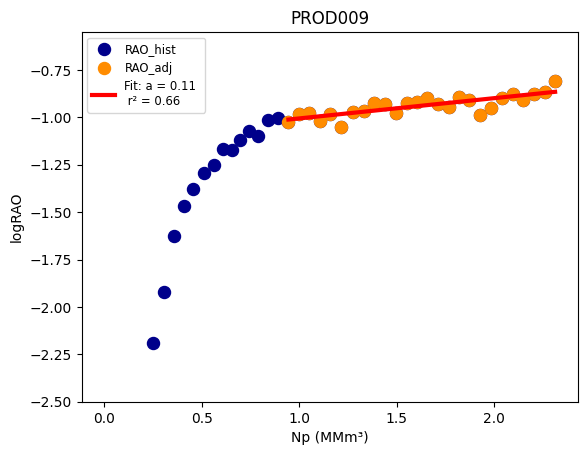

In [61]:
## Ajuste LogRAOxNp - Well 6

w_num = 6

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.9
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

5.916694896694905


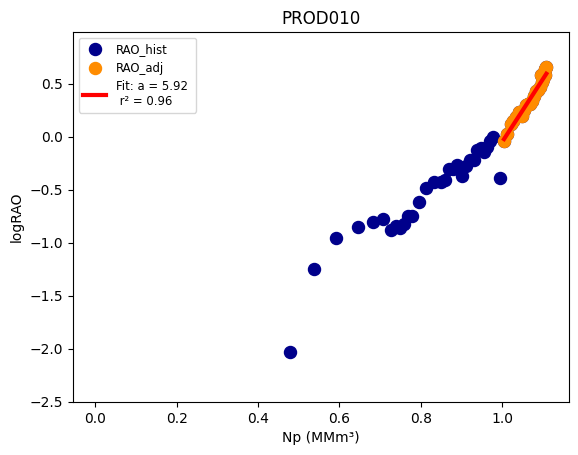

In [62]:
## Ajuste LogRAOxNp - Well 7

w_num = 7

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.0847920597316105


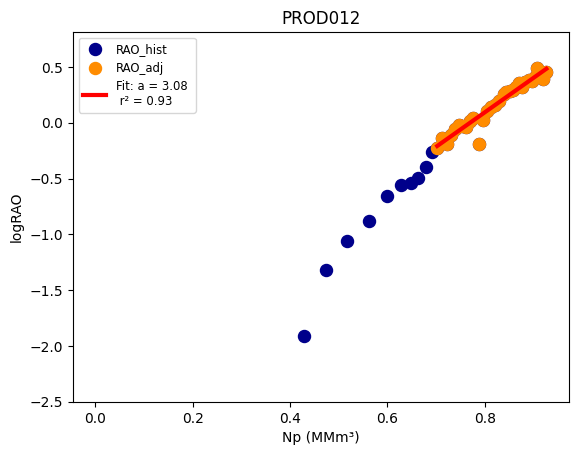

In [63]:
## Ajuste LogRAOxNp - Well 8

w_num = 8

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.6716552194326306


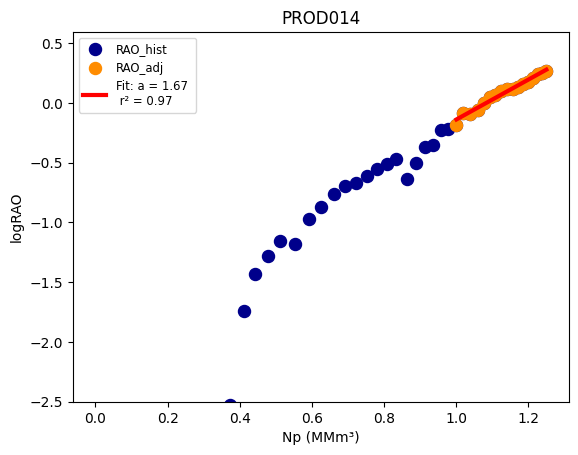

In [64]:
## Ajuste LogRAOxNp - Well 9

w_num = 9

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.017887179733196


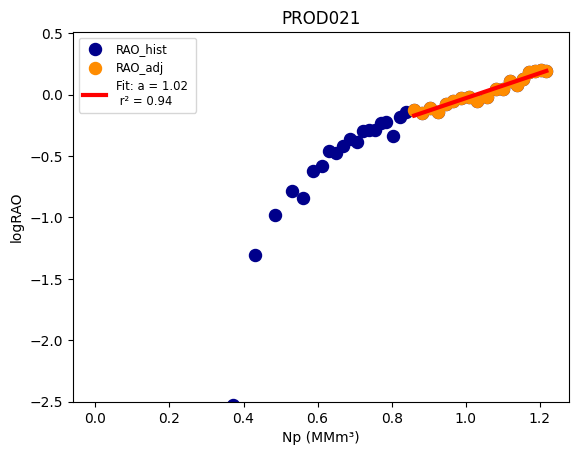

In [65]:
## Ajuste LogRAOxNp - Well 10

w_num = 10

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.85
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.281812094363806


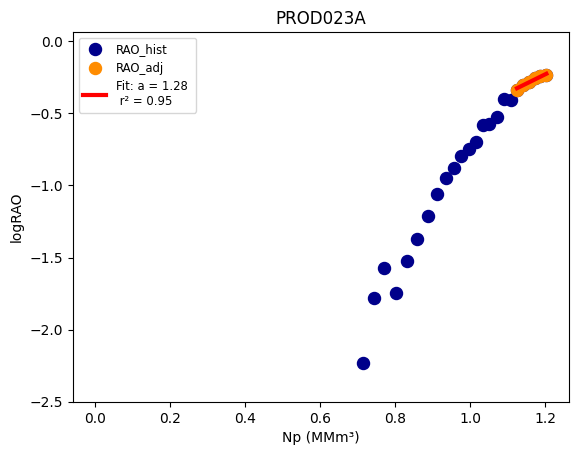

In [66]:
## Ajuste LogRAOxNp - Well 11

w_num = 11

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.11
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.321963723883817


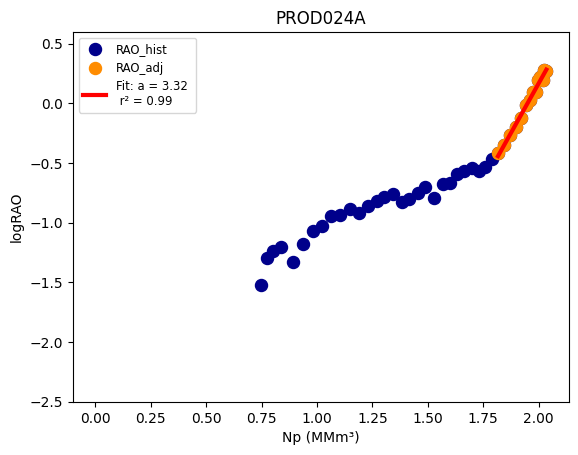

In [67]:
## Ajuste LogRAOxNp - Well 12

w_num = 12

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2751630559127751


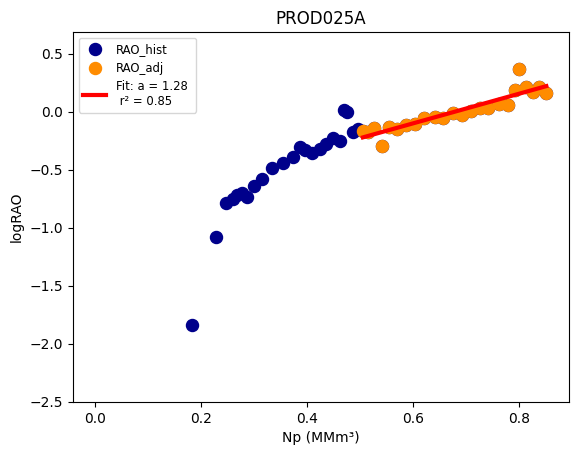

In [68]:
## Ajuste LogRAOxNp - Well 13

w_num = 13

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

In [69]:
aw

array([0.487587  , 1.47029454, 0.83959624, 1.07375541, 1.03000597,
       1.29546352, 0.10686654, 5.9166949 , 3.08479206, 1.67165522,
       1.01788718, 1.28181209, 3.32196372, 1.27516306])

## Módulo Previsão

### Ajuste Ponto de Partida

In [70]:
# Definição de BHP e IP

for w in range(len(wells_prod)):
  BHPP[w] = wells_prod_hist_df[w]["BHP"].values[-1]
  IP[w] = (wells_prod_hist_df[w]["qo"].values[-1]+wells_prod_hist_df[w]["qw"].values[-1])/(p_prev[-1]-BHPP[0])

BHPP, IP

(array([228., 267., 190., 195., 258., 289., 239., 300., 314., 217., 292.,
        185., 246., 314.]),
 array([25.25642204, 12.49242401, 17.35607529, 14.12187004,  8.59162712,
        12.52945709, 24.49107552,  5.01178265,  9.03602219, 13.68982029,
        16.04758072,  9.94950008,  9.77667999, 12.76399803]))

In [71]:
# Definição de BHP e II

for w in range(len(wells_inj)):
  BHPI[w] = wells_inj_hist_df[w]["BHP"].values[-1]
  II[w] = wells_inj_hist_df[w]["qwi"].values[-1]/(BHPI[0]-p_prev[-1])

BHPI, II

(array([351., 351., 347., 351., 352., 352., 340., 352., 352., 350., 350.]),
 array([ 64.44252777,  27.81554604,  18.09915733,  43.69993973,
         43.1998291 ,  23.33838654, 110.76207733,  32.34033585,
         95.35398102,  16.52738762,  15.14613628]))

In [72]:
verif=p_prev[-1]-BHPP
verif

Array([ 81.009094,  42.009094, 119.009094, 114.009094,  51.009094,
        20.009094,  70.009094,   9.009094,  -4.990906,  92.009094,
        17.009094, 124.009094,  63.009094,  -4.990906], dtype=float32)

In [73]:
## Ajustando BHP dos poços num 8 e 13 para evitar DD negativo
## Assumindo DD de 50 kgf/cm²

BHPP[8] = p_prev[-1]-50
IP[8] = (wells_prod_hist_df[8]["qo"].values[-1]+wells_prod_hist_df[8]["qw"].values[-1])/(p_prev[-1]-BHPP[8])

BHPP[13] = p_prev[-1]-50
IP[13] = (wells_prod_hist_df[13]["qo"].values[-1]+wells_prod_hist_df[13]["qw"].values[-1])/(p_prev[-1]-BHPP[13])

IP[8], IP[13]

(14.639999389648438, 20.68000030517578)

In [74]:
## Ajuste de IP para corrigir ponto de partida da bruta

# Produtores
IP[0] = 23.0
IP[1] = 20.0
IP[2] = 12.0
IP[3] = 10.0
IP[4] = 12.0
IP[5] = 40.0
IP[6] = 27.0
IP[7] = 25.0
# IP[8] =
IP[9] = 12.0
IP[10] = 60.0
IP[11] = 6.0
IP[12] = 12.0
# IP[13] =

# Injetores
# II[0] =
# II[1] =
# II[2] =
# II[3] =
# II[4] =
# II[5] =
II[6] = 170.0
# II[7] =
II[8] = 100.0
II[9] = 20.0
II[10] = 18.5

In [75]:
BHPP, IP

(array([228.        , 267.        , 190.        , 195.        ,
        258.        , 289.        , 239.        , 300.        ,
        259.00909424, 217.        , 292.        , 185.        ,
        246.        , 259.00909424]),
 array([23.        , 20.        , 12.        , 10.        , 12.        ,
        40.        , 27.        , 25.        , 14.63999939, 12.        ,
        60.        ,  6.        , 12.        , 20.68000031]))

In [76]:
verif=p_prev[-1]-BHPP
verif

Array([ 81.009094,  42.009094, 119.009094, 114.009094,  51.009094,
        20.009094,  70.009094,   9.009094,  50.      ,  92.009094,
        17.009094, 124.009094,  63.009094,  50.      ], dtype=float32)

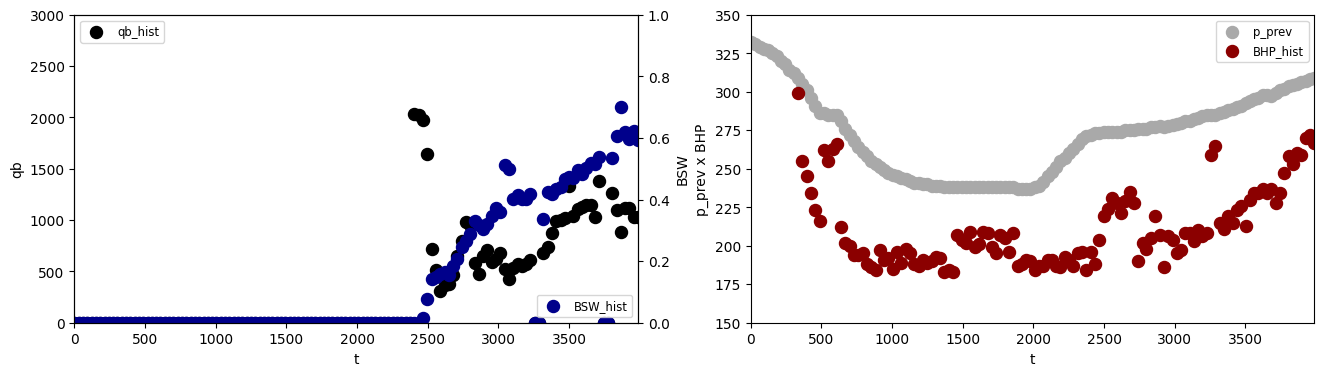

In [77]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 1

BHPPw = wells_prod_hist_df[w_num]["BHP"].values

qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow[i]+qww[i]
  if (qow[i]+qww[i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww[i]/(qow[i]+qww[i])


## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, hist_df.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="BSW_hist", color="darkblue", s=75)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, p_prev, label="p_prev", color="darkgrey", s=75)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.set_xlabel("t")
ax3.set_ylabel("p_prev x BHP")
ax3.set_xlim(0, hist_df.iloc[-1, 6])
ax3.set_ylim(150, 350)
ax3.legend(fontsize='small')

plt.show()

### Condições Operacionais

In [78]:
## Definição dos Poços e Condições Operacionais

wells_op_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_wells_operation.xlsx').iloc[:,:-2]
wells_op_df

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [79]:
wells_prod_op_df = wells_op_df[wells_op_df['type'] == 'prod']
wells_prod_op_df

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [80]:
Qbmax = wells_prod_op_df["q_lim"].values
BHPPmin_op = wells_prod_op_df["bhp_lim"].values

In [81]:
wells_inj_op_df = wells_op_df[wells_op_df['type'] == 'inj']
wells_inj_op_df

,well,type,q_lim,bhp_lim
14,INJ003,inj,5000,350
15,INJ005,inj,5000,350
16,INJ006,inj,5000,350
17,INJ007,inj,5000,350
18,INJ010,inj,5000,350
19,INJ015,inj,5000,350
20,INJ017,inj,5000,350
21,INJ019,inj,5000,350
22,INJ021,inj,5000,350
23,INJ022,inj,5000,350


In [82]:
Qwimax = wells_inj_op_df["q_lim"].values
BHPImax_op = wells_inj_op_df["bhp_lim"].values

In [83]:
## Limites do sistema

group_lim_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_group_limits.xlsx')
group_lim_df

,system,limit
0,liquid,15500
1,oil,15500
2,water_prod,13950
3,water_inj,21700
4,gas,2000000


In [84]:
topside_lim=group_lim_df['limit'].values
topside_lim

array([  15500,   15500,   13950,   21700, 2000000])

### Configuração da Previsão

In [85]:
date=hist_df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=132, freq=None)

In [86]:
# Última data fornecida
last_date = date_time[-1]

# Quantidade de meses na previsão
n_months = 120

# Gerar novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, n_months+1)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31',
               ...
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31', '2034-02-28', '2034-03-31',
               '2034-04-30', '2034-05-31'],
              dtype='datetime64[ns]', length=120, freq=None)

In [87]:
## Forecast Dataframe

fc_df = pd.DataFrame(new_dates, columns=['Date'])
fc_df = pd.concat([hist_df, fc_df], ignore_index=True).fillna(0)
fc_df["t"] = (fc_df["Date"]-fc_df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
fc_df["dt"]=fc_df["t"].diff().fillna(0)
fc_df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
247,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# fc_train = fc.copy()

p_fc=fc_df["Press"].values
npp_fc=fc_df["Np"].values
gp_fc=fc_df["Gp"].values
wp_fc=fc_df["Wp"].values
winj_fc=fc_df["Winj"].values
t_fc=fc_df["t"].values
dt_fc=fc_df["dt"].values
qo_fc=fc_df["qo"].values
qg_fc=fc_df["qg"].values
qw_fc=fc_df["qw"].values
qwi_fc=fc_df["qwi"].values
bo_fc=fc_df["Bo"].values
bg_fc=fc_df["Bg"].values
rs_fc=fc_df["Rs"].values
rp_fc=fc_df["Rp"].values
f_fc=fc_df["F"].values
eo_fc=fc_df["Eo"].values
eg_fc=fc_df["Eg"].values
efw_fc=fc_df["Efw"].values
p_prev_fc=fc_df["P_prev"].values
so_fc=fc_df["So"].values
sw_fc=fc_df["Sw"].values
sg_fc=fc_df["Sg"].values
we_ebm_fc=fc_df["We_ebm"].values
wen_fc=fc_df["We_aqui"].values
pa_med_fc=fc_df["Pa_med"].values
cct_fc=fc_df["cct"].values
Vpp_fc=fc_df["Vpp"].values
uo_fc=fc_df["Viso"].values
ug_fc=fc_df["Visg"].values

# fc.iloc[df.shape[0]-2:df.shape[0]+1,5:25]

In [89]:
## Forecast Dataframe - Wells Prod

wells_prod_fc_df = []

for i in range(len(wells_prod)):
  wells_prod_fc_df.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_prod_fc_df[i].insert(0, 'well', wells_prod[i])
  wells_prod_fc_df[i] = pd.concat([wells_prod_hist_df[i], wells_prod_fc_df[i]], ignore_index=True).fillna(0)
  wells_prod_fc_df[i]["t"] = (wells_prod_fc_df[i]["Date"]-wells_prod_fc_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_fc_df[i]["dt"] = wells_prod_fc_df[i]["t"].diff().fillna(0)

wells_prod_fc_df[-1].tail()
# wells_prod_fc_df[0]["RAO"].iloc[-1]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
247,PROD025A,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0,0.0
248,PROD025A,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0,0.0
249,PROD025A,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0,0.0
250,PROD025A,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0,0.0
251,PROD025A,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0,0.0


In [90]:
## Forecast Dataframe - Wells Inj

wells_inj_fc_df = []

for i in range(len(wells_inj)):
  wells_inj_fc_df.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_inj_fc_df[i].insert(0, 'well', wells_inj[i])
  wells_inj_fc_df[i] = pd.concat([wells_inj_hist_df[i], wells_inj_fc_df[i]], ignore_index=True).fillna(0)
  wells_inj_fc_df[i]["t"] = (wells_inj_fc_df[i]["Date"]-wells_inj_fc_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_fc_df[i]["dt"]=wells_inj_fc_df[i]["t"].diff().fillna(0)

wells_inj_fc_df[-1].tail()

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
247,INJ023,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0
248,INJ023,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0
249,INJ023,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0
250,INJ023,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0
251,INJ023,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0


In [91]:
qow_fc = []
qgw_fc = []
qww_fc = []
qwiw_fc = []
RAO_fc = []
nppw_fc = []
BHPP_fc = []
BHPI_fc = []
qbw_fc = []

for i in range(len(wells_prod)):
  qow_fc.append(wells_prod_fc_df[i]["qo"].values)
  qgw_fc.append(wells_prod_fc_df[i]["qg"].values)
  qww_fc.append(wells_prod_fc_df[i]["qw"].values)
  RAO_fc.append(wells_prod_fc_df[i]["RAO"].values)
  nppw_fc.append(wells_prod_fc_df[i]["Np"].values)
  BHPP_fc.append(wells_prod_fc_df[i]["BHP"].values)
  qbw_fc.append(wells_prod_fc_df[i]["qo"].values+wells_prod_fc_df[i]["qw"].values)

for j in range(len(wells_inj)):
  qwiw_fc.append(wells_inj_fc_df[j]["qwi"].values)
  BHPI_fc.append(wells_inj_fc_df[j]["BHP"].values)

# RAO_fc[-1][:], nppw_fc[-1][:]

### Modelo de Programação Linear

In [92]:
## SIMPLEX

# warnings.filterwarnings("ignore", category=DeprecationWarning) # Ocultação de Warnings
# print(f"BHPP antes = {BHPP}") # Verificação

def model_lp(n, P_lp, bo_lp, bg_lp, P_target=pb, freq=1, smooth=True, max_iter=100, lim=1, adj=5):
  # Inicialização do Modelo de Programação Linear
  RAOm = np.zeros(len(wells_prod))
  RGOm = np.zeros(len(wells_prod))
  Btm = np.zeros(len(wells_prod))
  BHPPmin_qb = np.zeros(len(wells_prod))
  BHPPmin = np.zeros(len(wells_prod))
  BHPImax_qwi = np.zeros(len(wells_inj))
  BHPImax = np.zeros(len(wells_inj))
  c = []
  A_ub = []
  A_eq = []
  A_ebm = []
  A_liq = []
  A_oil = []
  A_wat = []
  A_inj = []
  A_gas = []
  A_reinj = []
  A_inj_min = []
  b_ub = []
  b_eq = []
  b_ebm = 0
  b_liq = topside_lim[0]
  b_oil = topside_lim[1]
  b_wat = topside_lim[2]
  b_inj = topside_lim[3]
  b_gas = topside_lim[4]
  b_reinj = 0
  b_inj_min = 10000
  bounds = []

  # Poços Produtores
  for i in range(len(wells_prod)):
    # Atualização dos valores de RAO e RGO a cada timestep
    RAOm[i]=10**(aw[i]/10**6*(nppw_fc[i][hist_df.shape[0]+n-1]-nppw_fc[i][hist_df.shape[0]+n-2])+np.log10(RAO_fc[i][hist_df.shape[0]+n-1]))
    RGOm[i]=Rsi

    # Função Objetivo
    c.append(IP[i]*(1+RGOm[i])/(1+RAOm[i]))

    # Restrição de Balanço de Materiais
    ## Condições de Superfície
    # A_ebm.append(-IP[i])
    # b_ebm -= IP[i]*P_lp
    ## Condições de Reservatório
    # Btm[i] = (bo_lp+RGOm[i]*bg_lp+RAOm[i]*Bw)/(1+RAOm[i])
    Btm[i] = (bo_lp+RAOm[i]*Bw)/(1+RAOm[i])
    if P_lp <= P_target:
      A_ebm.append(-Btm[i]*IP[i])
      b_ebm -= Btm[i]*IP[i]*P_lp
    else:
      A_ebm.append(Btm[i]*IP[i])
      b_ebm += Btm[i]*IP[i]*P_lp
    # Restrição de Capacidade de Líquido
    A_liq.append(-IP[i])
    b_liq-=IP[i]*P_lp

    # Restrição de Capacidade de Óleo
    A_oil.append(-IP[i]/(1+RAOm[i]))
    b_oil-=IP[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Água Produzida
    A_wat.append(-IP[i]*RAOm[i]/(1+RAOm[i]))
    b_wat-=IP[i]*RAOm[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Injeção
    A_inj.append(0)
    b_inj+=0

    # Restrição de Balanço de Capacidade de Gás
    A_gas.append(-IP[i]*RGOm[i]/(1+RAOm[i]))
    b_gas-=IP[i]*RGOm[i]/(1+RAOm[i])*P_lp

    # Restrição de Reinjeção
    A_reinj.append(-RAOm[i]*IP[i]/(1+RAOm[i]))
    b_reinj += -RAOm[i]*IP[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Injeção Mínima
    A_inj_min.append(0)
    b_inj_min-=0

    # Limites das variáveis de decisão (bounds)
    if (i == 8) or (i == 13):
      bounds.append((P_lp-50, P_lp-50))
    else:
      BHPPmin_qb[i]=P_lp-Qbmax[i]/IP[i]
      BHPPmin[i]=max(BHPPmin_op[i], BHPPmin_qb[i])
      bounds.append((BHPPmin[i], P_lp)) # Com fechamento de poços
      # bounds.append((BHPP[i], P_lp-5)) # Sem fechamento de poços
      # bounds.append((None, None)) # Teste sem limitação

  # Poços Injetores
  for j in range(len(wells_inj)):
    # Função Objetivo
    c.append(0)

    # Restrição de Balanço de Materiais
    ## Condições de Superfície
    # A_ebm.append(-II[j])
    # b_ebm -= II[j]*P_lp
    ## Condições de Reservatório
    if P_lp <= P_target:
      A_ebm.append(-Bw*II[j])
      b_ebm -= Bw*II[j]*P_lp
    else:
      A_ebm.append(Bw*II[j])
      b_ebm += Bw*II[j]*P_lp

    # Restrição de Capacidade de Líquido
    A_liq.append(0)
    b_liq-=0

    # Restrição de Capacidade de Óleo
    A_oil.append(0)
    b_oil-=0

    # Restrição de Capacidade de Água Produzida
    A_wat.append(0)
    b_wat-=0

    # Restrição de Capacidade de Injeção
    A_inj.append(II[j])
    b_inj += II[j]*P_lp

    # Restrição de Capacidade de Gás
    A_gas.append(0)
    b_gas-=0

    # Restrição de Reinjeção
    A_reinj.append(-II[j])
    b_reinj += -II[j]*P_lp

    # Restrição de Capacidade de Injeção Mínima
    A_inj_min.append(-II[j])
    b_inj_min += II[j]*P_lp

    # Limites das variáveis de decisão (bounds)
    BHPImax_qwi[j]=P_lp+Qwimax[j]/II[j]
    BHPImax[j]=min(BHPImax_op[j], BHPImax_qwi[j])
    bounds.append((P_lp, BHPImax[j])) # Com fechamento de poços
    # bounds.append((P_lp+5, BHPImax[j])) # Sem fechamento de poços
    # bounds.append((BHPImax_op[j], BHPImax_op[j]))
    # bounds.append((None, None)) # Teste sem limitação

  # Inclusão das Restrições no Modelo de Programação Linear
  if P_lp == P_target:
    A_eq.append(A_ebm)
    b_eq.append(b_ebm)
  else:
    A_ub.append(A_ebm)
    b_ub.append(b_ebm)

  A_ub.append(A_liq)
  b_ub.append(b_liq)
  A_ub.append(A_oil)
  b_ub.append(b_oil)
  A_ub.append(A_wat)
  b_ub.append(b_wat)
  A_ub.append(A_inj)
  b_ub.append(b_inj)
  A_ub.append(A_gas)
  b_ub.append(b_gas)
  A_ub.append(A_reinj)
  b_ub.append(b_reinj)
  A_ub.append(A_inj_min)
  b_ub.append(-1*b_inj_min)

  # Ajuste manual dos limites das variáveis de decisão
  # bounds[0] = (190, 190) ## Ajuste manual poço 0
  # bounds[2] = (190, 190) ## Ajuste manual poço 2
  # bounds[3] = (190, 190) ## Ajuste manual poço 3
  # bounds[7] = (190, 190) ## Ajuste manual poço 11
  # print(bounds)

  # Execução do Modelo de Programação Linear
  if n % freq == 0:
    if smooth == True:
      iter = 0
      results=[]
      sum_abs=[]
      while iter < max_iter:
        if P_lp == P_target:
          result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs-ds')
        else: # P_lp != P_target
          result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
        if result.success:
          # print(f"Timestep {n}: {result.message}")
          results.append(result)
          # Variação do BHP antes e depois da otimização
          delta_p=result.x[0:len(wells_prod)]-BHPP # Produtores
          delta_i=result.x[len(wells_prod):]-BHPI # Injetores
          delta = np.concatenate((delta_p, delta_i))
          # print(delta)
          sum_abs.append(np.sum(np.abs(delta)))
          # print(sum_abs)
          # print(f"Timestep {n} | Iter {iter} | MA {sum_abs[-1]:0.2f}")
          if (iter > 2) and ((sum_abs[-2]-sum_abs[-1]) < 0.001):
            print(f"Timestep {n}: {results[-1].message} -> iter = {iter}")
            return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]
          # Verificação das variações e atualização dos bounds
          for d in range(len(delta)):
            if delta[d] < -lim:
              bounds[d] = (bounds[d][0]*(1+adj/100), bounds[d][1])
            elif delta[d] > lim:
              bounds[d] = (bounds[d][0], bounds[d][1]*(1-adj/100))
        else: # not result.success
          if not results:
            print(f"Timestep {n}: Optimization terminated unsuccessfully. (No optimal solution) -> iter = {iter}")
            return BHPP, BHPI
          else: # results não é vazia
            print(f"Timestep {n}: {results[-1].message} -> iter = {iter} (Cut)")
            return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]
        iter+=1
      print(f"Timestep {n}: {results[-1].message} -> iter = {iter}")
      return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]

    else: # Otim == False
      if P_lp == P_target:
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs-ds')
      else: # P_lp != P_target
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
      # Impressão dos Resultados
      print(f"Timestep {n}: {result.message}")
      # Retorno dos Resultados para o Modelo de Reservatórios
      if result.success:
          return result.x[0:len(wells_prod)], result.x[len(wells_prod):]
      else: # not result.success
          return BHPP, BHPI
  else: # n % freq != 0
    return BHPP, BHPI

# Verificação
# topside_lim[3]
# BHPP_d, BHPI_d = model_lp_simplex(0, p_prev_fc[hist_df.shape[0]+0-1], bo_fc[hist_df.shape[0]+0-1], bg_fc[hist_df.shape[0]+0-1])
# BHPP_d, BHPI_d = model_lp_simplex(1, p_prev_fc[hist_df.shape[0]+0-1], bo_fc[hist_df.shape[0]+0-1], bg_fc[hist_df.shape[0]+0-1])
# print(f"BHPP depois = {BHPP_d}")
# print(f"dBHPP = {BHPP_d-BHPP}")
# BHPP_d, BHPI_d

### Execução da Previsão

In [93]:
## Forecast

inicio_fc = time.time()

for n in range(n_months):
  ## Previsão de vazões
  # RAO = uo_fc[hist_df.shape[0]+n-1]*f_krw(sw_fc[hist_df.shape[0]+n-1], nw)*bo_fc[hist_df.shape[0]+n-1]/(uw*f_krow(sw_fc[hist_df.shape[0]+n-1], now)*Bw)*90
  # RAO_fc = 10**(a*(npp_fc[hist_df.shape[0]+n-1]-npp_fc[hist_df.shape[0]+n-2])+np.log10(qw_fc[hist_df.shape[0]+n-1]/qo_fc[hist_df.shape[0]+n-1]))
  # RGO_fc = uo_fc[hist_df.shape[0]+n-1]*f_krg(sg_fc[hist_df.shape[0]+n-1], ng)*bo_fc[hist_df.shape[0]+n-1]/(ug_fc[hist_df.shape[0]+n-1]*f_krog(sg_fc[hist_df.shape[0]+n-1], nog)*bg_fc[hist_df.shape[0]+n-1])+rs_fc[hist_df.shape[0]+n-1]
  RGO = Rsi

  ## Modelo de programação linear
  P_target = p0 # Pressão inicial do reservatório
  freq = 1 # Frequência da otimização
  smooth = True # Modelo com método iterativo de suavização
  max_iter = 10 # Máximo número de iterações da suavização
  lim = 5.0 # Limite de variação de BHP entre os timesteps
  adj = 5.0 # Fator percentual para ajuste dos limites de BHP
  BHPP, BHPI = model_lp(n, p_prev_fc[hist_df.shape[0]+n-1], bo_fc[hist_df.shape[0]+n-1], bg_fc[hist_df.shape[0]+n-1], P_target=P_target, freq=freq, smooth=smooth, max_iter=max_iter, lim=lim, adj=adj)

  ## Cálculo das vazões

  ## Produtores
  for i in range(len(wells_prod)):
    RAO_fc[i][hist_df.shape[0]+n]=10**(aw[i]/10**6*(nppw_fc[i][hist_df.shape[0]+n-1]-nppw_fc[i][hist_df.shape[0]+n-2])+np.log10(RAO_fc[i][hist_df.shape[0]+n-1]))
    # IP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-1]
    # BHPP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-2]
    IP_fc=IP[i]
    BHPP_fc[i][hist_df.shape[0]+n]=BHPP[i] # BHP Constante

    # Vazão do poço
    qbw_fc[i][hist_df.shape[0]+n]=IP_fc*(p_prev_fc[hist_df.shape[0]+n-1]-BHPP_fc[i][hist_df.shape[0]+n])
    # print(qb)
    qow_fc[i][hist_df.shape[0]+n]=qbw_fc[i][hist_df.shape[0]+n]/(1+RAO_fc[i][hist_df.shape[0]+n])
    # print(qo_fc[i][hist_df.shape[0]+n])
    qgw_fc[i][hist_df.shape[0]+n]=qow_fc[i][hist_df.shape[0]+n]*RGO
    qww_fc[i][hist_df.shape[0]+n]=qow_fc[i][hist_df.shape[0]+n]*RAO_fc[i][hist_df.shape[0]+n]

    # Acumulada do poço
    nppw_fc[i][hist_df.shape[0]+n]=nppw_fc[i][hist_df.shape[0]+n-1]+qow_fc[i][hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]

    # Vazões do campo
    qo_fc[hist_df.shape[0]+n]+=qow_fc[i][hist_df.shape[0]+n]
    qg_fc[hist_df.shape[0]+n]+=qgw_fc[i][hist_df.shape[0]+n]
    qw_fc[hist_df.shape[0]+n]+=qww_fc[i][hist_df.shape[0]+n]

  ## Injetores
  for j in range(len(wells_inj)):
    # II=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-1]
    # BHPI=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-2]
    II_fc = II[j]
    BHPI_fc[j][hist_df.shape[0]+n]=BHPI[j]

    # Vazão do poço
    qwiw_fc[j][hist_df.shape[0]+n]=II_fc*(BHPI_fc[j][hist_df.shape[0]+n]-p_prev_fc[hist_df.shape[0]+n-1])
    # qwiw_fc[j][hist_df.shape[0]+n]=qwiw_fc[j][hist_df.shape[0]+n-1] ## Qwi constante

    # Vazão do campo
    qwi_fc[hist_df.shape[0]+n]+=qwiw_fc[j][hist_df.shape[0]+n]

  ## Previsão de acumuladas - Campo
  npp_fc[hist_df.shape[0]+n]=npp_fc[hist_df.shape[0]+n-1]+qo_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  gp_fc[hist_df.shape[0]+n]=gp_fc[hist_df.shape[0]+n-1]+qg_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  wp_fc[hist_df.shape[0]+n]=wp_fc[hist_df.shape[0]+n-1]+qw_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  winj_fc[hist_df.shape[0]+n]=winj_fc[hist_df.shape[0]+n-1]+qwi_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  rp_fc[hist_df.shape[0]+n]=gp_fc[hist_df.shape[0]+n]/npp_fc[hist_df.shape[0]+n]

  ## Previsão de fatores volume-formação e viscosidades
  if p_prev_fc[hist_df.shape[0]+n-1] < pb:
      bo_fc[hist_df.shape[0]+n] = bo_a * p_prev_fc[hist_df.shape[0]+n-1] + bo_b
      rs_fc[hist_df.shape[0]+n] = rs_a * p_prev_fc[hist_df.shape[0]+n-1] + rs_b
  else:
      bo_fc[hist_df.shape[0]+n] = bob - co * (p_prev_fc[hist_df.shape[0]+n-1] - pb)
      rs_fc[hist_df.shape[0]+n] = Rsi
  bg_fc[hist_df.shape[0]+n] = bg_a*p_prev_fc[hist_df.shape[0]+n-1]**(bg_b)
  uo_fc[hist_df.shape[0]+n] = viso_a*np.log(p_prev_fc[hist_df.shape[0]+n-1])+viso_b
  ug_fc[hist_df.shape[0]+n] = visg_a*p_prev_fc[hist_df.shape[0]+n-1]+visg_b

  # Previsão de pressão
  new_vector = []
  new_vector += [qo_fc[hist_df.shape[0]+n]]+[qg_fc[hist_df.shape[0]+n]]+[qw_fc[hist_df.shape[0]+n]]+[qwi_fc[hist_df.shape[0]+n]]+[bo_fc[hist_df.shape[0]+n]]+[bg_fc[hist_df.shape[0]+n]]+[p_prev_fc[hist_df.shape[0]+n-1]]
  # new_vector += [qo_fc[hist_df.shape[0]+n]]+[qg_fc[hist_df.shape[0]+n]]+[qw_fc[hist_df.shape[0]+n]]+[qwi_fc[hist_df.shape[0]+n]]+[bo_fc[hist_df.shape[0]+n]]+[bg_fc[hist_df.shape[0]+n]]
  new_vector = np.array(new_vector)
  # print(new_vector)
  new_vector = new_vector.reshape(1, new_vector.shape[0])

  # Normalizando
  # new_vector[:,0] = (new_vector[:,0] - qo_min) / (qo_max - qo_min)
  # new_vector[:,1] = (new_vector[:,1] - qg_min) / (qg_max - qg_min)
  # new_vector[:,2] = (new_vector[:,2] - qw_min) / (qw_max - qw_min)
  # new_vector[:,3] = (new_vector[:,3] - qwi_min) / (qwi_max - qwi_min)
  # new_vector[:,4] = (new_vector[:,4] - bo_min) / (bo_max - bo_min)
  # new_vector[:,5] = (new_vector[:,5] - bg_min) / (bg_max - bg_min)
  # new_vector[:,6] = (new_vector[:,6] - p_min) / (p_max - p_min)
  new_vector = scaler.transform(new_vector)

  # new_vector = scaler.transform((new_vector.reshape(1,-1)))
  # new_vector = new_vector.reshape(1,-1)/max_scaler
  new_vector = new_vector.reshape((1, new_vector.shape[0], new_vector.shape[1]))
  X_fc = jnp.concatenate([X_fc, new_vector], axis=0)
  # print(X_fc.shape)
  # result = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_fc)
  result = best_state.apply_fn(best_state.params, X_fc[-1])
  # print(result.item())
  # p_prev_fc[hist_df.shape[0]+n]=result[-1]
  p_prev_fc[hist_df.shape[0]+n]=result.item()
  # pa_med_fc[hist_df.shape[0]+n]=p_fc[0]*(1-(wen_fc[hist_df.shape[0]+n]/Wei_est))

  ## Previsão de saturações
  cct_fc[hist_df.shape[0]+n] = (1 + (Swi * cw / (1 - Swi) + cf) * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0]))
  Vpp_fc[hist_df.shape[0]+n] = Vp * (1 + cf * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0]))
  so_fc[hist_df.shape[0]+n] = ((N_est*10**6) - npp_fc[hist_df.shape[0]+n]) *bo_fc[0] / Vpp_fc[hist_df.shape[0]+n]
  sw_fc[hist_df.shape[0]+n] = (Swi * Vp * (1 - cw * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0])) + ((winj_fc[hist_df.shape[0]+n] - wp_fc[hist_df.shape[0]+n] + wen_fc[hist_df.shape[0]+n]) * Bw)) / Vpp_fc[hist_df.shape[0]+n]
  sg_fc[hist_df.shape[0]+n] = bg_fc[hist_df.shape[0]+n] * (G - gp_fc[hist_df.shape[0]+n] - ((N_est*10**6) - npp_fc[hist_df.shape[0]+n]) * rs_fc[hist_df.shape[0]+n] - cct_fc[hist_df.shape[0]+n] * m * (N_est*10**6) * bo_fc[0] / bg_fc[0]) / Vpp_fc[hist_df.shape[0]+n]

fim_fc = time.time()
tempo_fc = fim_fc - inicio_fc
print(f"\nTempo de execução: {tempo_fc:0.2f} segundos")

# fc_df.iloc[hist_df.shape[0]-1:fc_df.shape[0],:20]

Timestep 0: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 4
Timestep 1: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 6
Timestep 2: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 6
Timestep 3: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 6
Timestep 4: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 6
Timestep 5: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 6
Timestep 6: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 8
Timestep 7: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 8
Timestep 8: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 8
Timestep 9: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 8
Timestep 10: Optimization terminated successfully. (HiGHS Status 7: Optimal) -> iter = 8
Timestep 11: Optimization termi

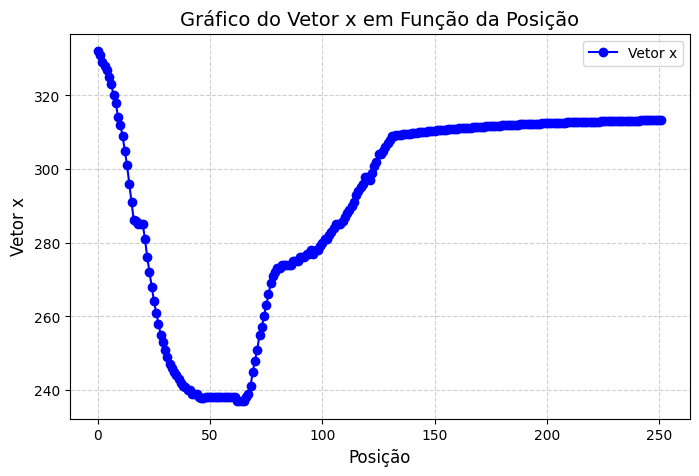

In [94]:
# Criando o gráfico
plt.figure(figsize=(8, 5))  # Define o tamanho da figura
plt.plot(np.arange(len(p_prev_fc)), p_prev_fc, marker='o', linestyle='-', color='b', label='Vetor x')  # Plota o vetor x

# Adicionando rótulos e título
plt.xlabel('Posição', fontsize=12)
plt.ylabel('Vetor x', fontsize=12)
plt.title('Gráfico do Vetor x em Função da Posição', fontsize=14)

# Adicionando grade
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.show()

### Gráficos

#### Campo

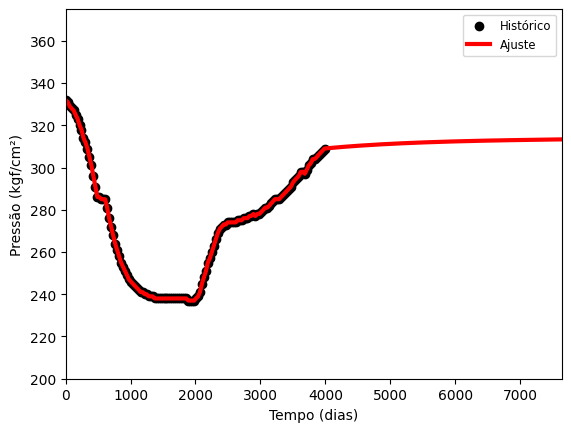

In [95]:
## Gráfico de pressões

plt.scatter(t, p, label="Histórico", color="black")
plt.plot(t_fc, p_prev_fc, label=f"Ajuste", color="red", linewidth=3)
# plt.plot(t_fc, pa_med_fc, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("Tempo (dias)")
plt.ylabel("Pressão (kgf/cm²)")
plt.xlim(0, fc_df.iloc[-1, 6])
plt.ylim(200, 375)
plt.show()

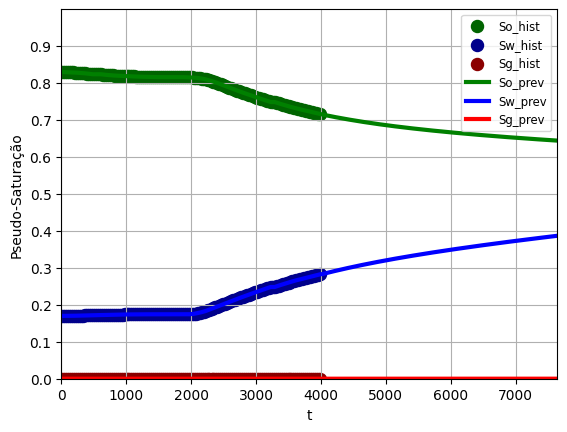

In [96]:
## Gráfico de saturações

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.scatter(t, So, label="So_hist", color="darkgreen", s=75)
plt.scatter(t, Sw, label="Sw_hist", color="darkblue", s=75)
plt.scatter(t, Sg, label="Sg_hist", color="darkred", s=75)
plt.plot(t_fc, so_fc, label="So_prev", color="green", linewidth=3)
plt.plot(t_fc, sw_fc, label="Sw_prev", color="blue", linewidth=3)
plt.plot(t_fc, sg_fc, label="Sg_prev", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, fc_df.iloc[-1, 6])
plt.show()

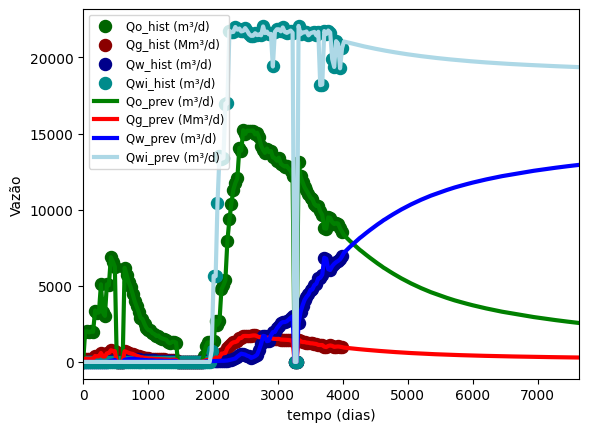

In [97]:
## Gráfico de vazões

plt.scatter(t, qo, label="Qo_hist (m³/d)", color="darkgreen", s=75)
plt.scatter(t, qg/1000, label="Qg_hist (Mm³/d)", color="darkred", s=75)
plt.scatter(t, qw, label="Qw_hist (m³/d)", color="darkblue", s=75)
plt.scatter(t, qwi, label="Qwi_hist (m³/d)", color="darkcyan", s=75)
plt.plot(t_fc, qo_fc, label=f"Qo_prev (m³/d)", color="green", linewidth=3)
plt.plot(t_fc, qg_fc/1000, label=f"Qg_prev (Mm³/d)", color="red", linewidth=3)
plt.plot(t_fc, qw_fc, label=f"Qw_prev (m³/d)", color="blue", linewidth=3)
plt.plot(t_fc, qwi_fc, label=f"Qwi_prev (m³/d)", color="lightblue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("tempo (dias)")
plt.ylabel("Vazão")
plt.xlim(0, fc_df.iloc[-1, 6])
plt.show()

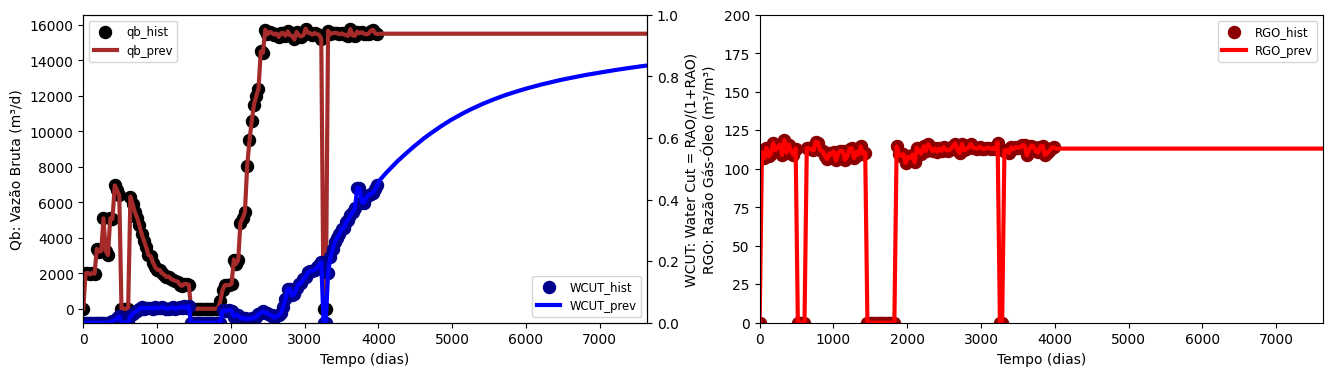

In [98]:
## Gráficos de Qb, BSW e RGO - Campo

qb_hist = np.zeros(len(t))
RGO = np.zeros(len(t))
BSW = np.zeros(len(t))
for i in range(len(t)):
  qb_hist[i]=qo[i]+qw[i]
  if qo[i] == 0:
    RGO[i]=0
  else:
    RGO[i]=qg[i]/qo[i]
  if (qo[i]+qw[i]) == 0:
    BSW[i]=0
  else:
    BSW[i]=qw[i]/(qo[i]+qw[i])

qb_fc = np.zeros(len(t_fc))
RGO_fc = np.zeros(len(t_fc))
BSW_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  qb_fc[i]=qo_fc[i]+qw_fc[i]
  if qo_fc[i] == 0:
    RGO_fc[i]=0
  else:
    RGO_fc[i]=qg_fc[i]/qo_fc[i]
  if (qo_fc[i]+qw_fc[i]) == 0:
    BSW_fc[i]=0
  else:
    BSW_fc[i]=qw_fc[i]/(qo_fc[i]+qw_fc[i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Subplot para Qb e BSW
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qb_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qb_fc, label="qb_prev", color="brown", linewidth=3)
ax1.set_xlabel("Tempo (dias)")
ax1.set_ylabel("Qb: Vazão Bruta (m³/d)")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
# ax1.set_ylim(0, 20000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSW, label="WCUT_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSW_fc, label="WCUT_prev", color="blue", linewidth=3)
ax2.set_ylabel("WCUT: Water Cut = RAO/(1+RAO)")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para RGO
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, RGO, label="RGO_hist", color="darkred", s=75)
ax3.plot(t_fc, RGO_fc, label="RGO_prev", color="red", linewidth=3)
ax3.set_xlabel("Tempo (dias)")
ax3.set_ylabel("RGO: Razão Gás-Óleo (m³/m³)")
ax3.set_xlim(0, fc_df.iloc[-1, 6])
ax3.set_ylim(0, 200)
ax3.legend(fontsize='small')

#### Poço

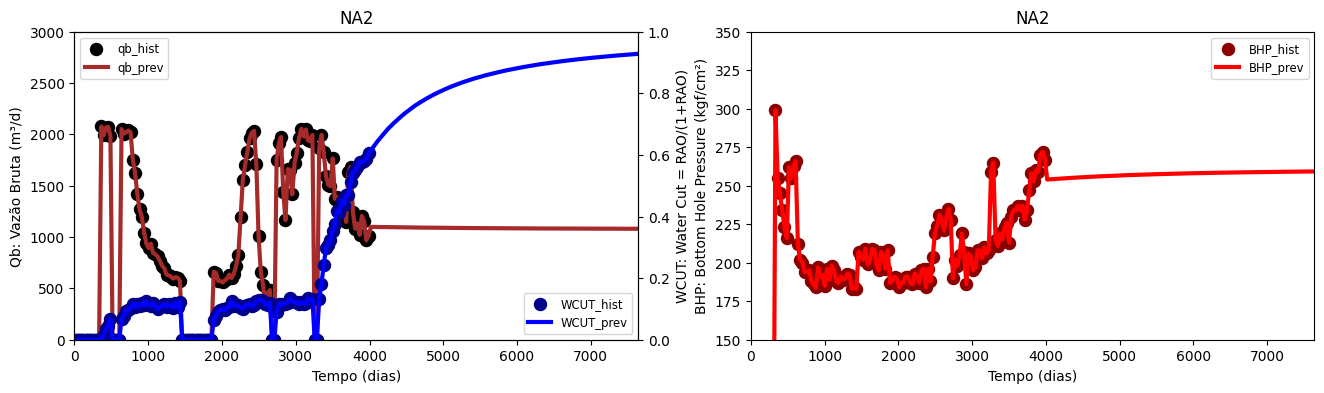

In [99]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 1
qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
BHPPw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow_fc[w_num][i]+qww_fc[w_num][i]
  BHPPw[i]=BHPP_fc[w_num][i]
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

BSWw_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw_fc[i]=0
  else:
    BSWw_fc[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qbw_fc[w_num], label="qb_prev", color="brown", linewidth=3)
ax1.set_title(wells_prod[w_num])
ax1.set_xlabel("Tempo (dias)")
ax1.set_ylabel("Qb: Vazão Bruta (m³/d)")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="WCUT_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSWw_fc, label="WCUT_prev", color="blue", linewidth=3)
ax2.set_ylabel("WCUT: Water Cut = RAO/(1+RAO)")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
# ax3.scatter(t, p, label="p_prev", color="darkgrey", s=75)
# ax3.plot(t_fc, p_prev_fc, label="p_prev_fc", color="blue", linewidth=3)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.plot(t_fc,BHPP_fc[w_num], label="BHP_prev", color="red", linewidth=3)
ax3.set_title(wells_prod[w_num])
ax3.set_xlabel("Tempo (dias)")
ax3.set_ylabel("BHP: Bottom Hole Pressure (kgf/cm²)")
ax3.set_xlim(0, fc_df.iloc[-1, 6])
ax3.set_ylim(150, 350)
ax3.legend(fontsize='small')

plt.show()

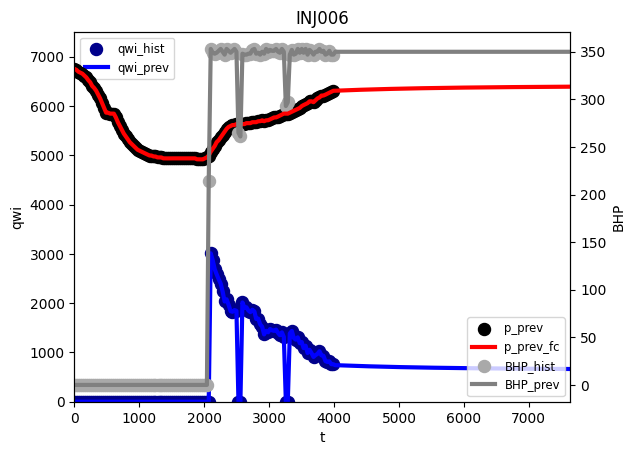

In [100]:
## Gráfico de Qwi - Poço

wi_num = 2

qwiw_hist = np.zeros(len(t))
BHPIw_hist = np.zeros(len(t))
for i in range(len(t)):
  qwiw_hist[i]=qwiw_fc[wi_num][i]
  BHPIw_hist[i]=BHPI_fc[wi_num][i]

# Criar subplot de Qwi
ax1 = plt.subplot(1, 1, 1)
ax1.scatter(t, qwiw_hist, label="qwi_hist", color="darkblue", s=75)
ax1.plot(t_fc, qwiw_fc[wi_num], label="qwi_prev", color="blue", linewidth=3)
ax1.set_title(wells_inj[wi_num])
ax1.set_xlabel("t")
ax1.set_ylabel("qwi")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
ax1.set_ylim(0, 7500)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BHP compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, p, label="p_prev", color="black", s=75)
ax2.plot(t_fc, p_prev_fc, label="p_prev_fc", color="red", linewidth=3)
ax2.scatter(t, BHPIw_hist, label="BHP_hist", color="darkgrey", s=75)
ax2.plot(t_fc, BHPI_fc[wi_num], label="BHP_prev", color="grey", linewidth=3)
ax2.set_ylabel("BHP")
# ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

plt.show()